# Main

# 조화소영 프로젝트

1. 행정동별 생활밀종업종별 매출액 데이터 수집 (2019~2022) 
   > 생활밀종업종 범주화 (1.음식점/2.교육/3.여가/4.생필품/5.의료및패션/6.서적및문구/7.가구및전자제품/8.숙박/9.전자상거래업/10.기타)


2. 데이터 전처리 (생활밀종업종별로 인코딩+상권코드별로 행정동 매칭+데이터정규화(Min-Max))
   
3. 각 연도별로 나누어서 군집화 진행 

4. 연도별로 행정동별 업종 매출 추이가 어떻게 변화했으며, 이에 따라 군집이 어떻게 달라지는 지 파악 (매출 vs 상점 수)

5. 연도별로 매출 및 군집이 달라진다면, 이것이 코로나 확진자 발생 추이와 관련이 있는 지 파악 (코로나 전인 2019년과 그 이후를 중점으로 분석하며, 급 상점 수가 감소하는 시기인 2022년을 주의깊게 볼 것)
   
6. 매출 감소가 각 상권발달에 미치는 영향은?

- 연도별 데이터 조인 + 상권코드별 행정동 매칭 + 분기당 매출 금액, 점포수만 컬럼 남기기 : 영재 
  * 점포 수: 가장 마지막 분기 데이터만 활용 : 소윤 
    * ~2021년: 4분기 
    * ~2022년: 3분기 
  * 매출금액: 분기별 매출 금액 총합 : 화정 
    * ~2021년: 1+2+3+4
    * ~2022년: 1+2+3+3

- 서비스 업종별로 나누는 함수 : 현민 

- 데이터 정규화 (min-max) : 화정 

In [2]:
# 필수라이브러리 
# matplotlib 한글 깨짐 방지

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# import PublicDataReader as pdr

fm.get_fontconfig_fonts()
font_location = '/data/notebook_files/fonts/esamanru_Medium.ttf'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
fprop = fm.FontProperties(fname=font_location)

# matplotlib.rc('font', family=font_name)

<ipython-input-2-7cb82bf20ad9>:13: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


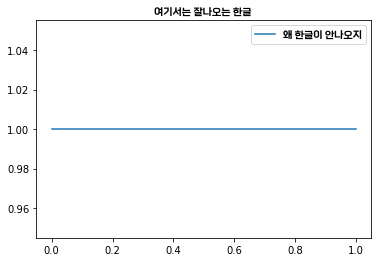

In [3]:
# 한글 깨짐 방지 예제
fig = plt.figure()
plt.plot((1, 1), label='왜 한글이 안나오지')
plt.title('여기서는 잘나오는 한글 ', fontproperties=fprop)
plt.legend(prop=fprop)
plt.show()  

## 데이터 분석 및 탐색(EDA)

In [4]:
# 서비스_업종_코드_명 분류 기준 dictionaries
classification_dicts = {"음식점":
                            ["한식음식점",
                             "중식음식점",
                             "일식음식점",
                             "양식음식점",
                             "패스트푸드점",
                             "치킨전문점",
                             "분식전문점",
                             "호프-간이주점",
                             "제과점",
                             "커피-음료", ]
    ,
                        "교육": ["일반교습학원",
                               "외국어학원",
                               "예술학원",
                               "스포츠 강습",
                               ]
    ,
                        "의료": ["일반의원",
                               "치과의원",
                               "한의원",
                               "의약품",
                               "의료기기",
                               ]
    ,
                        "여가": ["당구장",
                               "골프연습장",
                               "PC방",
                               "스포츠클럽",
                               "노래방",
                               "미용실",
                               "네일숍",
                               "피부관리실",
                               "자동차미용",
                               "운동/경기용품",
                               "자전거 및 기타운송장비",
                               ]
    ,
                        "생필품": ["슈퍼마켓",
                                "편의점",
                                "미곡판매",
                                "육류판매",
                                "수산물판매",
                                "청과상",
                                "반찬가게",
                                "세탁소",
                                "가전제품수리",
                                "자동차수리",
                                "철물점",
                                ],
                        "의류 및 패션": ["일반의류",
                                    "신발",
                                    "가방",
                                    "안경",
                                    "시계및귀금속",
                                    "화장품",
                                    ]
    ,
                        "서적 및 문구": ["서적",
                                    "문구",
                                    "완구",
                                    ]
    ,
                        "가구 및 가전제품": ["인테리어",
                                      "조명용품",
                                      "섬유제품",
                                      "화초",
                                      "가구",
                                      "가전제품",
                                      "컴퓨터및주변장치판매",
                                      "핸드폰",
                                      ]
    ,
                        "숙박": ["여관",
                               "고시원",
                               ]
    ,
                        "기타": ["부동산중개업",
                               "애완동물",
                               ]
    ,
                        "전자상거래업": ["전자상거래업"]
    ,
                        }

In [5]:
# 서비스_업종_코드_명 분류 함수
def classfy_business(string):
    global classification_dicts
    for clss, businesses in classification_dicts.items():
        if string in businesses:
            return clss
    return 'None'

## 데이터 전처리 

In [6]:
sales_19 = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2019년.csv')
sales_20 = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2020년.csv')
sales_21 = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2021년.csv')
sales_22 = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2022년 3분기 까지.csv')

In [7]:
sales_total = pd.concat([sales_19, sales_20, sales_21, sales_22], axis=0)

In [8]:
sales_total

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2019,1,A,골목상권,2110001,이북5도청사,CS100001,한식음식점,650014084,22184,...,382,13204,6513,35,864,1963,4440,6123,6287,25
1,2019,1,A,골목상권,2110001,이북5도청사,CS100008,분식전문점,149671019,9936,...,45,4814,4151,34,1081,959,2627,2517,1748,12
2,2019,1,A,골목상권,2110001,이북5도청사,CS100009,호프-간이주점,18579744,348,...,177,166,110,0,18,50,62,63,84,6
3,2019,1,A,골목상권,2110001,이북5도청사,CS100010,커피-음료,5380734,156,...,60,78,24,0,6,6,0,48,42,3
4,2019,1,A,골목상권,2110001,이북5도청사,CS200016,당구장,6699067,414,...,141,375,22,52,40,0,120,127,57,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102968,2022,1,A,골목상권,2110001,이북5도청사,CS200001,일반교습학원,46710839,136,...,0,96,40,0,0,0,120,16,0,3
102969,2022,1,A,골목상권,2110001,이북5도청사,CS100010,커피-음료,20931521,2018,...,0,955,1009,0,382,342,380,581,279,*
102970,2022,1,A,골목상권,2110001,이북5도청사,CS100009,호프-간이주점,5119924,159,...,18,115,18,0,0,18,18,54,44,*
102971,2022,1,A,골목상권,2110001,이북5도청사,CS100008,분식전문점,92420017,10197,...,0,5872,3689,26,401,1191,2273,3093,2576,3


In [9]:
sales_total['서비스_업종_코드_명_재분류'] = sales_total['서비스_업종_코드_명'].apply(classfy_business)

In [10]:
sales_total.to_csv('sales_total_2022.csv')

# Hyeonmin 

# Cluster

In [471]:
df = pd.read_csv('/data/workspace_files/_year_all.csv')

In [493]:
calc = df[['code', 'year', 'cluster']]

In [494]:
calc = calc.sort_values(by='code').reset_index(drop=True)

In [495]:
calc.iloc[0]['code']

11110515

In [496]:
calc

,code,year,cluster
0,11110515,2019,3
1,11110515,2021,3
2,11110515,2022,3
3,11110515,2020,3
4,11110530,2019,1
...,...,...,...
1596,11740685,2019,2
1597,11740700,2020,3
1598,11740700,2019,3
1599,11740700,2021,3


In [42]:
find_year_equal_cluster(calc)

NameError: NameError: name 'find_year_equal_cluster' is not defined

In [45]:
sales_total = pd.read_csv('/data/notebook_files/sales_total_2019~2022.3q.csv')

/opt/python/envs/default/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (80) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
sales_total.columns

Index(['Unnamed: 0', '기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드',
       '상권_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '분기당_매출_금액', '분기당_매출_건수',
       '주중_매출_비율', '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율',
       '목요일_매출_비율', '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율',
       '시간대_06~11_매출_비율', '시간대_11~14_매출_비율', '시간대_14~17_매출_비율',
       '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율',
       '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율',
       '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수'

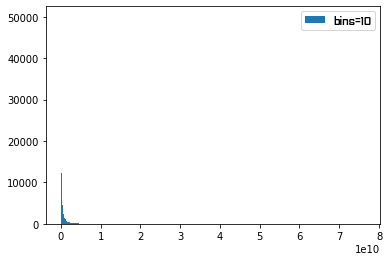

In [51]:
x = sales_total[sales_total['서비스_업종_코드_명_재분류'] =='음식점']['분기당_매출_금액'] 
plt.hist(sales_total[sales_total['서비스_업종_코드_명_재분류'] =='음식점']['분기당_매출_금액'], label='bins=10', bins=1000)
plt.legend(prop=fprop)
plt.show()  

In [54]:
plt.scatter(x,x)
plt.show()

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import math
scaler = StandardScaler()
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [62]:
x = np.array(sales_total[sales_total['서비스_업종_코드_명_재분류'] =='음식점']['분기당_매출_금액']).reshape(-1,1)

In [63]:
x_scale = scaler.fit(x)

In [65]:
x_scaled =x_scale.transform(x)

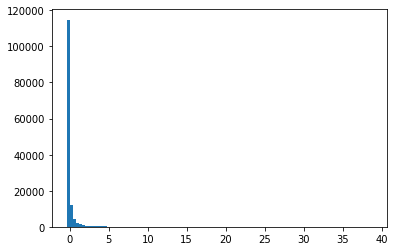

In [69]:
plt.hist(x_scaled, bins=100)
plt.show()

In [72]:
robust_scaler.fit(x)

# 훈련 데이터 스케일링
x_robust = robust_scaler.transform(x)

In [ ]:
x_robust

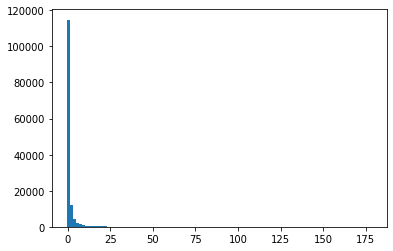

In [77]:
plt.hist(x_robust, bins=100)
plt.show()

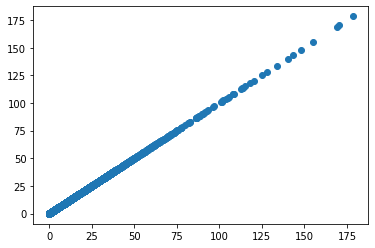

In [86]:
plt.scatter(x_robust,x_robust)

In [80]:
minmax_scaler.fit(x)
x_minmax_scaled = minmax_scaler.transform(x)

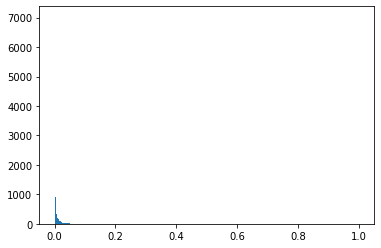

In [83]:
plt.hist(x_minmax_scaled, bins=10000)
plt.show()

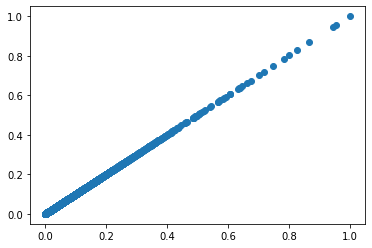

In [85]:
plt.scatter(x_minmax_scaled,x_minmax_scaled)

(array([2.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 5.0000e+00,
        2.1000e+01, 4.4000e+01, 1.1200e+02, 2.0000e+02, 4.7300e+02,
        9.1400e+02, 2.2800e+03, 5.0260e+03, 1.0357e+04, 1.6672e+04,
        2.2267e+04, 2.3953e+04, 2.0093e+04, 1.5599e+04, 1.1220e+04,
        5.7550e+03, 2.8860e+03, 1.0850e+03, 3.0800e+02, 4.3000e+01]),
 array([ 2.85793526,  3.17896778,  3.50000029,  3.82103281,  4.14206532,
         4.46309784,  4.78413035,  5.10516287,  5.42619538,  5.7472279 ,
         6.06826041,  6.38929293,  6.71032544,  7.03135796,  7.35239047,
         7.67342299,  7.9944555 ,  8.31548802,  8.63652053,  8.95755305,
         9.27858556,  9.59961808,  9.92065059, 10.24168311, 10.56271562,
        10.88374814]),
 <BarContainer object of 25 artists>)

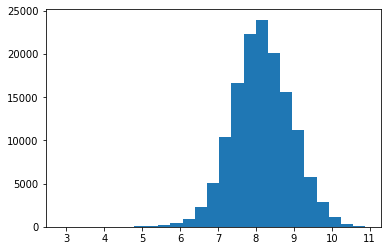

In [96]:
plt.hist(np.log10(x),bins=25)

# 행정동면적

In [248]:
import pandas

In [282]:
seoul_df = pd.read_csv('/data/notebook_files/서울시 건축물대장 법정동,행정동 코드정보.csv', )
seoul_dong_area = pd.read_csv('/data/notebook_files/행정동 면적.csv')

In [283]:
seoul_dong_area

,행정동,면적(k㎡)
0,흑석동,1.68
1,휘경2동,1.05
2,휘경1동,0.63
3,후암동,0.86
4,효창동,0.44
...,...,...
421,가산동,2.52
422,가리봉동,0.40
423,가락본동,1.13
424,가락2동,0.96


In [284]:
seoul_df = seoul_df[['행정동명', '시군구코드', '행정동코드']]

In [285]:
seoul_df['시군구코드'] = seoul_df['시군구코드'].astype(str)
seoul_df['행정동코드'] = seoul_df['행정동코드'].astype(str)
seoul_df['행정동_코드'] = seoul_df['시군구코드'] + seoul_df['행정동코드']
seoul_df['행정동_코드'] = seoul_df['행정동_코드'].astype(int)
# seoul_df =seoul_df[['행정동명','행정동_코드'] ]

In [286]:
seoul_df = seoul_df.iloc[:, [0, 3]]

In [288]:
seoul_dong_area.rename({'행정동': '행정동명'}, inplace=True, axis=1)

In [289]:
seoul_df = seoul_df.drop_duplicates()

In [290]:
imisi = pd.merge(seoul_df, seoul_dong_area, how='right', on="행정동명")

In [291]:
imisi[imisi.isnull()['행정동_코드']]

,행정동명,행정동_코드,면적(k㎡)
1,휘경2동,NaN,1.05
2,휘경1동,NaN,0.63
11,화곡8동,NaN,0.53
12,화곡6동,NaN,1.11
13,화곡4동,NaN,0.82
...,...,...,...
430,가양3동,NaN,0.50
431,가양2동,NaN,1.00
432,가양1동,NaN,4.70
436,가락2동,NaN,0.96


In [292]:
imisi[imisi.duplicated(subset='행정동명')]

,행정동명,행정동_코드,면적(k㎡)
9,화양동,11200710.0,1.16
43,청담동,11680502.0,2.33
136,옥수동,11200501.0,1.94
157,압구정동,1168011.0,2.53
158,압구정동,11680501.0,2.53
185,신사동,11680510.0,0.64
186,신사동,11380630.0,0.64
187,신사동,11620685.0,1.89
188,신사동,11680510.0,1.89
189,신사동,11380630.0,1.89


In [293]:
dong_code = pd.read_csv('/data/notebook_files/서울시 건축물대장 행정동코드들.csv')
dong_area = pd.read_csv('/data/notebook_files/행정구역 면적 수정.csv')

In [294]:
dong_code

,시군구코드,행정동코드,시군구명,행정동명
0,11590,600,동작구,흑석제3동
1,11590,590,동작구,흑석제2동
2,11590,580,동작구,흑석제1동
3,11590,605,동작구,흑석동
4,11230,730,동대문구,휘경제2동
...,...,...,...,...
723,11710,632,송파구,가락제2동
724,11710,631,송파구,가락제1동
725,11710,635,송파구,가락본동분소
726,11710,620,송파구,가락본동


In [295]:
dong_area

,시군구명,행정동명,면적 (k㎡)
0,종로구,소계,23.91
1,종로구,사직동,1.23
2,종로구,삼청동,1.49
3,종로구,부암동,2.27
4,종로구,평창동,8.87
...,...,...,...
446,강동구,길동,1.61
447,강동구,둔촌1동,0.92
448,강동구,둔촌2동,1.56
449,강동구,상일1동,1.82


In [296]:
dong_area = dong_area.drop(dong_area[dong_area['행정동명'] == '소계'].index)

In [297]:
dong_code['시군구코드'] = dong_code['시군구코드'].astype(str)
dong_code['행정동코드'] = dong_code['행정동코드'].astype(str)

In [298]:
dong_code['행정동_코드'] = dong_code['시군구코드'] + dong_code['행정동코드']

In [299]:
dong_code['행정동_코드'] = dong_code['행정동_코드'].astype('int64')

In [300]:
dong_code.drop(['시군구코드', '행정동코드'], axis=1, inplace=True)

In [302]:
a = pd.merge(dong_code, dong_area, how='right', on=['시군구명', '행정동명'])

In [303]:
a.drop_duplicates()

,시군구명,행정동명,행정동_코드,면적 (k㎡)
0,종로구,사직동,11110530.0,1.23
1,종로구,삼청동,11110540.0,1.49
2,종로구,부암동,11110550.0,2.27
3,종로구,평창동,11110560.0,8.87
4,종로구,무악동,11110570.0,0.36
...,...,...,...,...
425,강동구,길동,11740685.0,1.61
426,강동구,둔촌1동,NaN,0.92
427,강동구,둔촌2동,NaN,1.56
428,강동구,상일1동,NaN,1.82


In [304]:
a.to_csv('행정동_면적코드.csv')

In [305]:
a

,시군구명,행정동명,행정동_코드,면적 (k㎡)
0,종로구,사직동,11110530.0,1.23
1,종로구,삼청동,11110540.0,1.49
2,종로구,부암동,11110550.0,2.27
3,종로구,평창동,11110560.0,8.87
4,종로구,무악동,11110570.0,0.36
...,...,...,...,...
425,강동구,길동,11740685.0,1.61
426,강동구,둔촌1동,NaN,0.92
427,강동구,둔촌2동,NaN,1.56
428,강동구,상일1동,NaN,1.82


In [306]:
dongs = pd.read_csv('/data/notebook_files/행정동_면적코드_수정_수정.csv')

In [307]:
dongs

,시군구명,행정동명,행정동_코드,면적 (k㎡)
0,종로구,사직동,11110530.0,1.23
1,종로구,삼청동,11110540.0,1.49
2,종로구,부암동,11110550.0,2.27
3,종로구,평창동,11110560.0,8.87
4,종로구,무악동,11110570.0,0.36
...,...,...,...,...
421,강동구,길동,11740685.0,1.61
422,강동구,둔촌1동,NaN,0.92
423,강동구,둔촌2동,NaN,1.56
424,강동구,상일1동,NaN,1.82


In [308]:
dong_code['행정동명'] = dong_code['행정동명'].replace('(?P<one>[ㄱ-ㅎ|ㅏ-ㅣ|가-힣]+)제(?P<two>[0-9]동)', r'\1\2', regex=True)

In [309]:
dong_code

,시군구명,행정동명,행정동_코드
0,동작구,흑석3동,11590600
1,동작구,흑석2동,11590590
2,동작구,흑석1동,11590580
3,동작구,흑석동,11590605
4,동대문구,휘경2동,11230730
...,...,...,...
723,송파구,가락2동,11710632
724,송파구,가락1동,11710631
725,송파구,가락본동분소,11710635
726,송파구,가락본동,11710620


In [310]:
dongs.drop('행정동_코드', axis=1, inplace=True)

In [311]:
dongs

,시군구명,행정동명,면적 (k㎡)
0,종로구,사직동,1.23
1,종로구,삼청동,1.49
2,종로구,부암동,2.27
3,종로구,평창동,8.87
4,종로구,무악동,0.36
...,...,...,...
421,강동구,길동,1.61
422,강동구,둔촌1동,0.92
423,강동구,둔촌2동,1.56
424,강동구,상일1동,1.82


In [312]:
a = pd.merge(dong_code, dongs, how='right', on=['시군구명', '행정동명'])

In [313]:
a[a.isnull()['행정동_코드']]

,시군구명,행정동명,행정동_코드,면적 (k㎡)
109,중랑구,면목3.8동,NaN,1.63
180,노원구,상계10동,NaN,0.80
183,노원구,중계2.3동,NaN,0.90
331,관악구,보라매동,NaN,0.76


In [314]:
a.to_csv('행정동면적코드.csv')

# 화정

In [317]:
import pandas as pd
import numpy as np

In [318]:
# 서울시 우리마을가게 상권분석서비스(상권영역)
area_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권영역).csv', encoding='cp949')

# 서울시 우리마을가게 상권분석서비스(점포) - 2020~2022
store_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-점포).csv', encoding='cp949')

# 서울시 우리마을가게 상권분석서비스(점포) - 2019
store2019_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_점포)_2019년.csv', encoding='cp949')

# 서울시 건축물대장 법정동, 행정동 코드 정도 
seoul_df = pd.read_csv('/data/notebook_files/서울시 건축물대장 법정동,행정동 코드정보.csv', )

In [319]:
seoul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355 entries, 0 to 2354
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   시군구코드   2355 non-null   int64 
 1   법정동코드   2355 non-null   int64 
 2   행정동코드   2355 non-null   int64 
 3   시도명     2355 non-null   object
 4   시군구명    2354 non-null   object
 5   법정동명    2355 non-null   object
 6   행정동명    1243 non-null   object
 7   적용시작일   2355 non-null   int64 
 8   적용만료일   2355 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 165.7+ KB


In [320]:
seoul_df['시군구코드'] = seoul_df['시군구코드'].astype(str)
seoul_df['행정동코드'] = seoul_df['행정동코드'].astype(str)

In [321]:
seoul_df['시군구_행정동'] = seoul_df['시군구코드'] + seoul_df['행정동코드']

In [322]:
def change_function(area_code):
    global seoul_df
    area_code = str(area_code)
    temp = seoul_df[seoul_df['시군구_행정동'] == area_code]
    # print(temp, '\n',len(temp))
    if len(temp) > 1:
        # print(temp)
        temp = temp.iloc[0].to_dict()
    # return temp
    return temp['시군구명'] + ' ' + temp['행정동명']

In [323]:
change_function(11170650)

1455 용산구 이태원제1동
dtype: object

In [324]:
area_df['행정동_코드'].apply(lambda x: 1 if x > 11545600 else 0)

0 1
1 0
2 1
3 1
4 1
 ..
1666 0
1667 0
1668 1
1669 1
1670 0
Name: 행정동_코드, Length: 1671, dtype: int64

In [325]:
seoul_df

,시군구코드,법정동코드,행정동코드,시도명,시군구명,법정동명,행정동명,적용시작일,적용만료일,시군구_행정동
0,11680,11400,675,서울특별시,강남구,일원동,개포3동,20221223,99991231,11680675
1,11680,10300,675,서울특별시,강남구,개포동,개포3동,20221223,99991231,11680675
2,11680,10600,675,서울특별시,강남구,대치동,개포3동,20221223,99991231,11680675
3,11740,10300,526,서울특별시,강동구,상일동,상일제2동,20210701,99991231,11740526
4,11740,10300,525,서울특별시,강동구,상일동,상일제1동,20210701,99991231,11740525
...,...,...,...,...,...,...,...,...,...,...
2350,11110,12900,610,서울특별시,종로구,견지동,종로1.2가동,19880423,19981201,11110610
2351,11110,13000,610,서울특별시,종로구,와룡동,종로1.2가동,19880423,19981201,11110610
2352,11110,13100,610,서울특별시,종로구,권농동,종로1.2가동,19880423,19981201,11110610
2353,11110,13200,610,서울특별시,종로구,운니동,종로1.2가동,19880423,19981201,11110610


In [326]:
area_df

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934,438813,11545,11545710,NaN
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265,459431,11350,11350611,NaN
2,202112,A,골목상권,2110755,동일여자고등학교,192300,439070,11545,11545680,NaN
3,202112,A,골목상권,2110739,시흥3동 우편취급국,191289,438014,11545,11545690,NaN
4,202112,A,골목상권,2111017,송파나루역 3번,210222,445516,11710,11710562,NaN
...,...,...,...,...,...,...,...,...,...,...
1666,202112,U,관광특구,1001493,동대문패션타운 관광특구,200974,451975,11140,11140590,NaN
1667,202112,U,관광특구,1001494,종로?청계 관광특구,199768,452273,11110,11110615,NaN
1668,202112,U,관광특구,1001495,잠실 관광특구,210191,446339,11710,11710566,NaN
1669,202112,U,관광특구,1001496,강남 마이스 관광특구,205310,445727,11680,11680580,NaN


In [327]:
# store_df + store2019_df 병합 (새로운 컬럼 없이 아래로 통합)
store_df = store_df.append(store2019_df, ignore_index=True)

In [328]:
# 외식업 = 1, 서비스업 = 2, 소매업 = 3 
store_df['서비스_업종_번호'] = store_df['서비스_업종_코드'].str[2:3]

In [329]:
new_area = area_df[['상권_코드', '행정동_코드']]

store_df = pd.merge(store_df, new_area, how='inner', on='상권_코드')

In [330]:
store_df.head(3)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,서비스_업종_번호,행정동_코드
0,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6,6,0,0,17,1,0,3,11680580
1,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300042,주유소,1,1,0,0,0,0,0,3,11680580
2,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300041,예술품,10,10,0,0,0,0,0,3,11680580


In [331]:
import matplotlib.pyplot as plt
# matplotlib 한글 깨짐 방지

import matplotlib
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
font_location = '/data/notebook_files/fonts/esamanru_Medium.ttf'
# font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
fprop = fm.FontProperties(fname=font_location)

# matplotlib.rc('font', family=font_name)

<ipython-input-331-023d386b014c>:7: MatplotlibDeprecationWarning: 
The get_fontconfig_fonts function was deprecated in Matplotlib 3.5 and will be removed two minor releases later.
  fm.get_fontconfig_fonts()


TypeError: TypeError: __init__() got an unexpected keyword argument 'fontproperties'

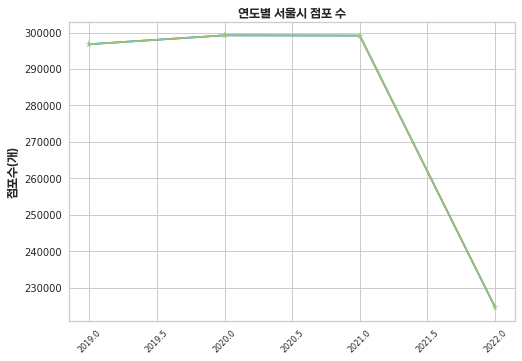

In [333]:
store_cnt_group = store_df.groupby(by=['기준_년_코드'])['점포_수'].count()

plt.plot(store_cnt_group)
plt.xticks(size=8, rotation=45)
plt.plot(store_cnt_group, marker='*', markersize=8)
plt.title('연도별 서울시 점포 수', fontproperties=fprop)
plt.ylabel('점포수(개)', fontproperties=fprop)
plt.legend(labels=['연도별 점포수 추이'], loc='best', fontsize=12, fontproperties=fprop)
plt.grid(True)
plt.show()

In [335]:
group2 = store_df.groupby(by=['기준_년_코드', '서비스_업종_번호'])['점포_수'].count()
group2

기준_년_코드 서비스_업종_번호
2019 1 48560
 2 112299
 3 135946
2020 1 49102
 2 113895
 3 136242
2021 1 49699
 2 113382
 3 136083
2022 1 37476
 2 84994
 3 102204
Name: 점포_수, dtype: int64

/opt/python/envs/default/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/python/envs/default/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/python/envs/default/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/python/envs/default/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/python/envs/default/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  fig.canvas.prin

<AxesSubplot:xlabel='기준_년_코드'>

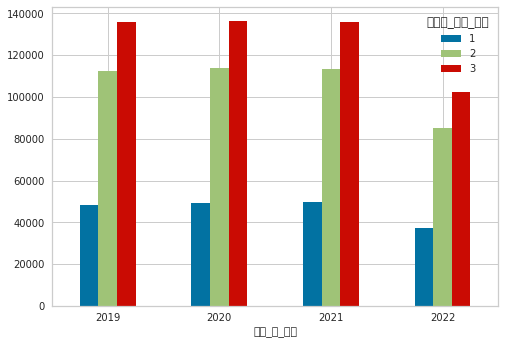

In [336]:
store_ctg_group = store_df.groupby(['기준_년_코드', '서비스_업종_번호'])['점포_수'].count().unstack()
store_ctg_group.plot.bar(rot=0)

<AxesSubplot:xlabel='기준_년_코드'>

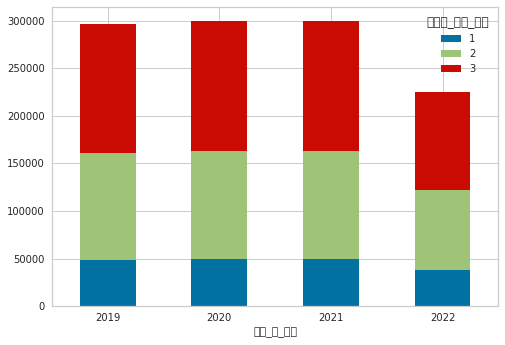

In [337]:
store_ctg_group.plot.bar(stacked=True, rot=0)

서비스업(2)과 소매업(3)이 크게 감소 (특히나 소매업 감소 大)

In [338]:
# unstack()과 결과 동일 
# store_ctg_group = store_df.groupby(['기준_년_코드', '서비스_업종_번호'])['점포_수'].count()
# store_ctg_group.reset_index().pivot(index='기준_년_코드',columns='서비스_업종_번호',values='점포_수')

In [339]:
store_df

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수,서비스_업종_번호,행정동_코드
0,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6,6,0,0,17,1,0,3,11680580
1,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300042,주유소,1,1,0,0,0,0,0,3,11680580
2,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300041,예술품,10,10,0,0,0,0,0,3,11680580
3,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300038,자동차부품,10,10,0,0,0,0,0,3,11680580
4,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300036,조명용품,14,14,0,0,0,0,0,3,11680580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119877,2020,2,R,전통시장,2130028,을지입구지하상가(을지로지하보도쇼핑센터),CS300022,화장품,0,1,0,0,0,0,1,3,11140550
1119878,2020,1,R,전통시장,2130028,을지입구지하상가(을지로지하보도쇼핑센터),CS300022,화장품,0,1,0,0,0,0,1,3,11140550
1119879,2019,1,R,전통시장,2130016,동대문상가B동,CS300014,신발,1,1,0,0,0,0,0,3,11110670
1119880,2019,2,R,전통시장,2130016,동대문상가B동,CS300014,신발,1,1,0,0,0,0,0,3,11110670


In [340]:
import pandas as pd
import numpy as np

In [341]:
# 서울시 우리마을가게 상권분석서비스(추정매출)
sales_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2020년.csv')

In [342]:
sales_df.head()

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,1,A,골목상권,2110001,이북5도청사,CS100001,한식음식점,673117215,26310,...,561,14980,8039,86,1875,2243,4809,7609,6398,28
1,2020,1,A,골목상권,2110001,이북5도청사,CS100008,분식전문점,87592085,10029,...,0,6377,2972,52,646,1849,2424,2492,1885,9
2,2020,1,A,골목상권,2110001,이북5도청사,CS100009,호프-간이주점,16496685,329,...,150,260,46,0,18,9,67,134,78,6
3,2020,1,A,골목상권,2110001,이북5도청사,CS100010,커피-음료,19442192,1562,...,54,678,773,0,166,345,533,252,155,8
4,2020,1,A,골목상권,2110001,이북5도청사,CS200001,일반교습학원,21617575,72,...,0,24,48,0,0,16,56,0,0,3


In [343]:
# 연도별로 
# 상권코드가 일치하는 항목끼리 
# 1분기 + 2분기 + 3분기 + 4분기 매출값을 더해라 

In [344]:
total_sales = sales_df.groupby(['기준_년_코드', '상권_코드'])['분기당_매출_금액'].sum()
total_sales_df = pd.DataFrame(total_sales.reset_index())
total_sales_df

,기준_년_코드,상권_코드,분기당_매출_금액
0,2020,1001491,319263592878
1,2020,1001492,1374959292839
2,2020,1001493,900581813177
3,2020,1001494,952259318256
4,2020,1001495,624689931100
...,...,...,...
1646,2020,2130322,18150412642
1647,2020,2130323,53527607088
1648,2020,2130324,27673886775
1649,2020,2130325,22191424052


In [345]:
total_sales_df = pd.DataFrame(sales_df.groupby(['기준_년_코드', '상권_코드'])['분기당_매출_금액'].sum().reset_index())
total_sales_df

,기준_년_코드,상권_코드,분기당_매출_금액
0,2020,1001491,319263592878
1,2020,1001492,1374959292839
2,2020,1001493,900581813177
3,2020,1001494,952259318256
4,2020,1001495,624689931100
...,...,...,...
1646,2020,2130322,18150412642
1647,2020,2130323,53527607088
1648,2020,2130324,27673886775
1649,2020,2130325,22191424052


In [346]:
def quartely_sales(df):
    sales_2022_df = df.loc[df['기준_년_코드'] == 2022]
    q3_df = sales_2022_df.loc[sales_2022_df['기준_분기_코드'] == 3]
    df = df.append(q3_df, ignore_index=True)

    total_sales_df = pd.DataFrame(df.groupby(['기준_년_코드', '상권_코드'])['분기당_매출_금액'].sum().reset_index())
    return total_sales_df

In [347]:
# 서울시 우리마을가게 상권분석서비스(추정매출) - 2022 ver 
sales2022_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2022년 3분기 까지.csv')

In [348]:
sales2022_df
sales2022_3_df = sales2022_df.loc[sales2022_df['기준_분기_코드'] == 3]  # 3분기 데이터만 필터링 

# sales2022_df + sales2022_3_df 병합 (새로운 컬럼 없이 아래로 통합)
sales2022_df = sales2022_df.append(sales2022_3_df, ignore_index=True)

In [349]:
quartely_sales(sales2022_df)

,기준_년_코드,상권_코드,분기당_매출_금액
0,2022,1001491,700111857274
1,2022,1001492,2360670854199
2,2022,1001493,1292570792422
3,2022,1001494,1498097077982
4,2022,1001495,628445270741
...,...,...,...
1645,2022,2130322,24188844033
1646,2022,2130323,86684973896
1647,2022,2130324,31169047227
1648,2022,2130325,29877634610


In [352]:
# import df
# # 데이터 정규화 
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df_minmax = scaler.fit_transform(df)

In [353]:
# df_minmax = scaler.fit_transform(df)

In [354]:
# 군집수 찾기 

# 다시 전처리

In [4]:
import pandas as pd
import numpy as np

In [5]:
# 추정 매출 데이터 로드 

# 서울시 우리마을가게 상권분석서비스(상권-추정매출)_2022년 3분기 까지.csv
sales_2022_df = pd.read_csv('/data/notebook_files/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2022년 3분기 까지.csv')

# 서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2021년.csv
sales_2021_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2021년.csv')

# 서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2020년.csv
sales_2020_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2020년.csv')

# 서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2019년.csv
sales_2019_df = pd.read_csv('/data/notebook_files/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2019년.csv')

In [6]:
# append로 연도별 데이터 단순 병합

all_sales_df = sales_2022_df.append([sales_2021_df, sales_2020_df, sales_2019_df], ignore_index=True)
all_sales_df.head()

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,9548586,2264,...,29,102,2162,225,1414,409,118,83,15,6
1,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300035,인테리어,103492276,370,...,0,370,0,0,0,0,0,370,0,4
2,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,55855797,130,...,0,0,130,0,0,130,0,0,0,6
3,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,8443170204,4794,...,0,2151,2643,0,105,388,987,1164,2150,6
4,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,576420408,8392,...,6,4326,3023,72,1757,2508,1961,650,398,5


In [7]:
# '서비스_업종_코드_명' 컬럼에서 외식업종에 해당하는 10개 업종 추출
# all_sales_df -> restaurant_sales_df

restaurant_list = ["한식음식점",
                   "중식음식점",
                   "일식음식점",
                   "양식음식점",
                   "패스트푸드점",
                   "치킨전문점",
                   "분식전문점",
                   "호프-간이주점",
                   "제과점",
                   "커피-음료", ]

restaurant_sales_df = all_sales_df[all_sales_df['서비스_업종_코드_명'].isin(restaurant_list)]
restaurant_sales_df['서비스_업종_코드_명'].value_counts()

한식음식점 22880
커피-음료 18600
호프-간이주점 17133
분식전문점 16860
치킨전문점 13552
중식음식점 13052
제과점 11180
패스트푸드점 10450
일식음식점 8255
양식음식점 7358
Name: 서비스_업종_코드_명, dtype: int64

In [8]:
# 기준 분기에서 4분기에 해당하는 행 삭제

restaurant_sales_df.drop(restaurant_sales_df[restaurant_sales_df['기준_분기_코드']==4].index, inplace=True )

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
restaurant_sales_df.head()

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
26,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS100010,커피-음료,4045897939,479843,...,4777,158347,274974,5687,116433,152512,86157,52308,20226,51
27,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS100008,분식전문점,14274980349,325918,...,7615,109777,164811,4453,75007,91680,53002,36632,13814,30
28,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS100006,패스트푸드점,2198345928,180625,...,7045,85629,83137,3373,51643,55195,33330,16618,8611,14
29,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS100005,제과점,3651812144,291792,...,13445,105589,167250,7388,82959,82707,58015,29913,11858,16
30,2022,3,U,관광특구,1001496,강남 마이스 관광특구,CS100004,양식음식점,3353695912,84760,...,2272,28750,44155,990,19011,26010,16386,7549,2956,35


In [10]:
# 점포수 열의 * -> 1 변환

restaurant_sales_df.replace({'점포수': '*'}, {'점포수': '1'}, inplace=True)
restaurant_sales_df['점포수'] = restaurant_sales_df['점포수'].astype('int64')

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<ipython-input-10-b7fa3e3f923a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_sales_df['점포수'] = restaurant_sales_df['점포수'].astype('int64')


In [11]:
restaurant_sales_df['점포수'] = restaurant_sales_df['점포수'].astype('int64')

<ipython-input-11-e75349675eb5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_sales_df['점포수'] = restaurant_sales_df['점포수'].astype('int64')


In [12]:
restaurant_sales_df['점포수'].value_counts()

3 25495
6 13923
9 7884
1 6332
12 5135
 ... 
875 1
407 1
442 1
382 1
492 1
Name: 점포수, Length: 600, dtype: int64

In [13]:
# 동일 상권 내 각 외식업종 매출금액, 매출건수, 점포수 합계
# restaurant_sales_df -> area_restaurant_sales_df

area_restaurant_sales_df = restaurant_sales_df.groupby(['기준_년_코드', '기준_분기_코드', '상권_코드'])[
    ['분기당_매출_금액', '분기당_매출_건수', '점포수']].sum().reset_index()

In [14]:
area_restaurant_sales_df

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,분기당_매출_건수,점포수
0,2019,1,1001491,54634552580,2086610,670
1,2019,1,1001492,141749712582,6813781,1693
2,2019,1,1001493,27392649743,1604310,562
3,2019,1,1001494,72021116242,3206295,1048
4,2019,1,1001495,62061731717,3396994,634
...,...,...,...,...,...,...
19251,2022,3,2130322,952603932,42330,63
19252,2022,3,2130323,1891064252,70789,68
19253,2022,3,2130324,1265423884,79050,43
19254,2022,3,2130325,233755939,10066,11


In [15]:
# 행정동 코드 + 상권 코드
dong_df = pd.read_csv('/data/notebook_files/(상권영역).csv', encoding='cp949')

dong_df = dong_df[['상권_코드', '행정동_코드']]
dong_df

,상권_코드,행정동_코드
0,2110753,11545710
1,2110427,11350611
2,2110755,11545680
3,2110739,11545690
4,2111017,11710562
...,...,...
1666,1001493,11140590
1667,1001494,11110615
1668,1001495,11710566
1669,1001496,11680580


In [16]:
# '상권_코드'를 기준으로 추정매출 데이터와 행정동 데이터 left join
# area_restaurant_sales_df -> sales_stores_df

sales_stores_df = pd.merge(area_restaurant_sales_df, dong_df, how='left', on='상권_코드')
sales_stores_df

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,분기당_매출_건수,점포수,행정동_코드
0,2019,1,1001491,54634552580,2086610,670,11170650
1,2019,1,1001492,141749712582,6813781,1693,11140520
2,2019,1,1001493,27392649743,1604310,562,11140590
3,2019,1,1001494,72021116242,3206295,1048,11110615
4,2019,1,1001495,62061731717,3396994,634,11710566
...,...,...,...,...,...,...,...
19251,2022,3,2130322,952603932,42330,63,11740620
19252,2022,3,2130323,1891064252,70789,68,11740660
19253,2022,3,2130324,1265423884,79050,43,11740685
19254,2022,3,2130325,233755939,10066,11,11740530


In [17]:

dong_name = pd.read_csv("/data/notebook_files/서울시 건축물대장 법정동,행정동 코드정보.csv")

dong_name['시군구코드'] = dong_name['시군구코드'].astype(str)
dong_name['행정동코드'] = dong_name['행정동코드'].astype(str)
dong_name['행정동_코드'] = dong_name['시군구코드'] + dong_name['행정동코드']
dong_name['행정동_코드'] = dong_name['행정동_코드'].astype(int)
dong_name = dong_name[['행정동_코드','행정동명']]
dong_name

,행정동_코드,행정동명
0,11680675,개포3동
1,11680675,개포3동
2,11680675,개포3동
3,11740526,상일제2동
4,11740525,상일제1동
...,...,...
2350,11110610,종로1.2가동
2351,11110610,종로1.2가동
2352,11110610,종로1.2가동
2353,11110610,종로1.2가동


In [18]:
sales_stores_df = pd.merge(sales_stores_df, dong_name, how='left', on='행정동_코드')
sales_stores_df

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,분기당_매출_건수,점포수,행정동_코드,행정동명
0,2019,1,1001491,54634552580,2086610,670,11170650,이태원제1동
1,2019,1,1001492,141749712582,6813781,1693,11140520,소공동
2,2019,1,1001492,141749712582,6813781,1693,11140520,소공동
3,2019,1,1001492,141749712582,6813781,1693,11140520,소공동
4,2019,1,1001492,141749712582,6813781,1693,11140520,소공동
...,...,...,...,...,...,...,...,...
43142,2022,3,2130322,952603932,42330,63,11740620,천호제3동
43143,2022,3,2130323,1891064252,70789,68,11740660,성내제3동
43144,2022,3,2130324,1265423884,79050,43,11740685,길동
43145,2022,3,2130325,233755939,10066,11,11740530,명일제1동


In [19]:
sales_stores_df.drop_duplicates(inplace=True)

In [20]:
sales_stores_df.isna().sum()

기준_년_코드 0
기준_분기_코드 0
상권_코드 0
분기당_매출_금액 0
분기당_매출_건수 0
점포수 0
행정동_코드 0
행정동명 0
dtype: int64

In [21]:
# 시구군명+행정동명+행정동_코드+면적.csv 

sq_area_df = pd.read_csv("/data/notebook_files/행정동면적코드_최종.csv")
sq_area_df

,시군구명,행정동명,행정동_코드,면적 (k㎡)
0,종로구,청운효자동,11110515,2.57
1,종로구,사직동,11110530,1.23
2,종로구,삼청동,11110540,1.49
3,종로구,부암동,11110550,2.27
4,종로구,평창동,11110560,8.87
...,...,...,...,...
420,강동구,성내2동,11740650,0.67
421,강동구,성내3동,11740660,0.71
422,강동구,길동,11740685,1.61
423,강동구,둔촌1동,11740690,0.92


In [22]:
sales_stores_area_df = pd.merge(sales_stores_df, sq_area_df, how='left', on='행정동_코드')
sales_stores_area_df

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,분기당_매출_건수,점포수,행정동_코드,행정동명_x,시군구명,행정동명_y,면적 (k㎡)
0,2019,1,1001491,54634552580,2086610,670,11170650,이태원제1동,용산구,이태원1동,0.57
1,2019,1,1001492,141749712582,6813781,1693,11140520,소공동,중구,소공동,0.95
2,2019,1,1001493,27392649743,1604310,562,11140590,광희동,중구,광희동,0.74
3,2019,1,1001494,72021116242,3206295,1048,11110615,종로1.2.3.4가동,종로구,종로1.2.3.4가동,2.35
4,2019,1,1001495,62061731717,3396994,634,11710566,오륜동,송파구,오륜동,3.17
...,...,...,...,...,...,...,...,...,...,...,...
19275,2022,3,2130322,952603932,42330,63,11740620,천호제3동,강동구,천호3동,0.79
19276,2022,3,2130323,1891064252,70789,68,11740660,성내제3동,강동구,성내3동,0.71
19277,2022,3,2130324,1265423884,79050,43,11740685,길동,강동구,길동,1.61
19278,2022,3,2130325,233755939,10066,11,11740530,명일제1동,강동구,명일1동,0.61


In [23]:
# 기준_년_코드, 행정동_코드 기준으로 groupby

sales_stores_area_df.groupby(['행정동_코드','기준_년_코드']).agg({'분기당_매출_금액':sum, '분기당_매출_건수':sum, '점포수':np.average, })

분기당_매출_금액 
 분기당_매출_건수 
 점포수 
 
 
 행정동_코드 
 기준_년_코드 
 
 
 
 
 
 
 
 11110515 
 2019 
 14556619880 
 819793 
 59.400000 
 
 
 2020 
 13474746423 
 710392 
 56.533333 
 
 
 2021 
 16501053050 
 826998 
 56.666667 
 
 
 2022 
 25734795800 
 1345940 
 31.533333 
 
 
 11110530 
 2019 
 222597215455 
 9810969 
 385.277778 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 11740685 
 2022 
 87037961471 
 4886490 
 100.761905 
 
 
 11740700 
 2019 
 18406769817 
 872371 
 63.800000 
 
 
 2020 
 18657175513 
 970776 
 64.133333 
 
 
 2021 
 15611069249 
 818331 
 58.600000 
 
 
 2022 
 15727131438 
 762356 
 32.333333 
 
 
 
 1601 rows × 3 columns

In [24]:
sales_stores_area_df['건당_매출액'] = round(sales_stores_area_df['분기당_매출_금액'] / sales_stores_area_df['분기당_매출_건수'], 0)
sales_stores_area_df

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,분기당_매출_건수,점포수,행정동_코드,행정동명_x,시군구명,행정동명_y,면적 (k㎡),건당_매출액
0,2019,1,1001491,54634552580,2086610,670,11170650,이태원제1동,용산구,이태원1동,0.57,26183.0
1,2019,1,1001492,141749712582,6813781,1693,11140520,소공동,중구,소공동,0.95,20803.0
2,2019,1,1001493,27392649743,1604310,562,11140590,광희동,중구,광희동,0.74,17074.0
3,2019,1,1001494,72021116242,3206295,1048,11110615,종로1.2.3.4가동,종로구,종로1.2.3.4가동,2.35,22462.0
4,2019,1,1001495,62061731717,3396994,634,11710566,오륜동,송파구,오륜동,3.17,18270.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19275,2022,3,2130322,952603932,42330,63,11740620,천호제3동,강동구,천호3동,0.79,22504.0
19276,2022,3,2130323,1891064252,70789,68,11740660,성내제3동,강동구,성내3동,0.71,26714.0
19277,2022,3,2130324,1265423884,79050,43,11740685,길동,강동구,길동,1.61,16008.0
19278,2022,3,2130325,233755939,10066,11,11740530,명일제1동,강동구,명일1동,0.61,23222.0


In [25]:
sales_stores_area_df['점포_밀집도'] = round(sales_stores_area_df['점포수'] / sales_stores_area_df['면적 (k㎡)'], 0)
sales_stores_area_df

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,분기당_매출_건수,점포수,행정동_코드,행정동명_x,시군구명,행정동명_y,면적 (k㎡),건당_매출액,점포_밀집도
0,2019,1,1001491,54634552580,2086610,670,11170650,이태원제1동,용산구,이태원1동,0.57,26183.0,1175.0
1,2019,1,1001492,141749712582,6813781,1693,11140520,소공동,중구,소공동,0.95,20803.0,1782.0
2,2019,1,1001493,27392649743,1604310,562,11140590,광희동,중구,광희동,0.74,17074.0,759.0
3,2019,1,1001494,72021116242,3206295,1048,11110615,종로1.2.3.4가동,종로구,종로1.2.3.4가동,2.35,22462.0,446.0
4,2019,1,1001495,62061731717,3396994,634,11710566,오륜동,송파구,오륜동,3.17,18270.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19275,2022,3,2130322,952603932,42330,63,11740620,천호제3동,강동구,천호3동,0.79,22504.0,80.0
19276,2022,3,2130323,1891064252,70789,68,11740660,성내제3동,강동구,성내3동,0.71,26714.0,96.0
19277,2022,3,2130324,1265423884,79050,43,11740685,길동,강동구,길동,1.61,16008.0,27.0
19278,2022,3,2130325,233755939,10066,11,11740530,명일제1동,강동구,명일1동,0.61,23222.0,18.0


In [26]:
#sales_stores_area_df.drop('기준_년분기_코드', axis=1)

In [27]:
sales_stores_area_df2 = sales_stores_area_df.groupby(['기준_년_코드', '기준_분기_코드'])[['건당_매출액', '점포_밀집도']].sum().reset_index()
sales_stores_area_df2

,기준_년_코드,기준_분기_코드,건당_매출액,점포_밀집도
0,2019,1,38322422.0,216133.0
1,2019,2,37325205.0,195172.0
2,2019,3,36513301.0,215242.0
3,2020,1,36894411.0,214269.0
4,2020,2,36588326.0,213336.0
5,2020,3,36136000.0,211050.0
6,2021,1,36473786.0,203659.0
7,2021,2,36628178.0,208504.0
8,2021,3,34598154.0,205437.0
9,2022,1,38823027.0,112372.0


In [28]:
sales_stores_area_df2['기준_년_코드'] = sales_stores_area_df2['기준_년_코드'].astype(str)
sales_stores_area_df2['기준_분기_코드'] = sales_stores_area_df2['기준_분기_코드'].astype(str)
sales_stores_area_df2['기준_년분기_코드'] = sales_stores_area_df2['기준_년_코드'] + sales_stores_area_df2['기준_분기_코드']
sales_stores_area_df2

,기준_년_코드,기준_분기_코드,건당_매출액,점포_밀집도,기준_년분기_코드
0,2019,1,38322422.0,216133.0,20191
1,2019,2,37325205.0,195172.0,20192
2,2019,3,36513301.0,215242.0,20193
3,2020,1,36894411.0,214269.0,20201
4,2020,2,36588326.0,213336.0,20202
5,2020,3,36136000.0,211050.0,20203
6,2021,1,36473786.0,203659.0,20211
7,2021,2,36628178.0,208504.0,20212
8,2021,3,34598154.0,205437.0,20213
9,2022,1,38823027.0,112372.0,20221


In [29]:
import matplotlib.pyplot as plt

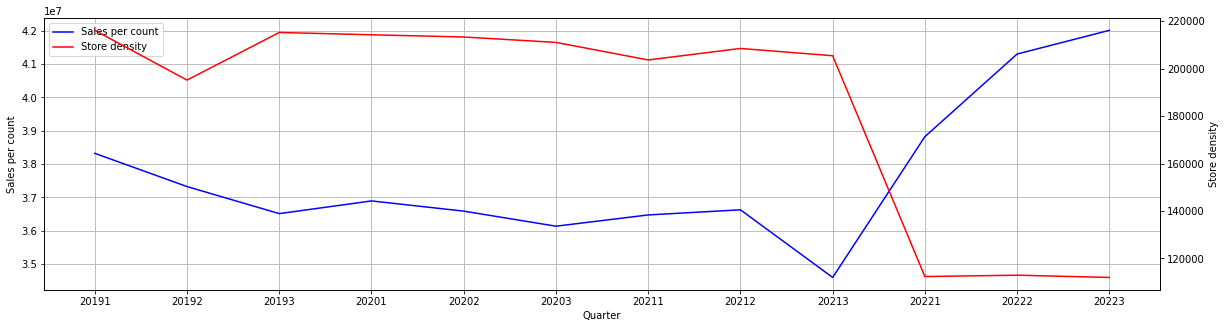

In [30]:
fig, ax1 = plt.subplots(figsize=(20, 5))

ax2 = ax1.twinx()
lns1 = ax1.plot(sales_stores_area_df2['기준_년분기_코드'], sales_stores_area_df2['건당_매출액'], label='Sales per count',
                color='blue')
lns2 = ax2.plot(sales_stores_area_df2['기준_년분기_코드'], sales_stores_area_df2['점포_밀집도'], label='Store density', color='red')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.grid()
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Sales per count')
ax2.set_ylabel('Store density')
plt.show()

In [31]:
sales_stores_area_df2.to_csv('년분기 건당_매출액, 점포_밀집도.csv')

In [32]:
sales_stores_area_df

,기준_년_코드,기준_분기_코드,상권_코드,분기당_매출_금액,분기당_매출_건수,점포수,행정동_코드,행정동명_x,시군구명,행정동명_y,면적 (k㎡),건당_매출액,점포_밀집도
0,2019,1,1001491,54634552580,2086610,670,11170650,이태원제1동,용산구,이태원1동,0.57,26183.0,1175.0
1,2019,1,1001492,141749712582,6813781,1693,11140520,소공동,중구,소공동,0.95,20803.0,1782.0
2,2019,1,1001493,27392649743,1604310,562,11140590,광희동,중구,광희동,0.74,17074.0,759.0
3,2019,1,1001494,72021116242,3206295,1048,11110615,종로1.2.3.4가동,종로구,종로1.2.3.4가동,2.35,22462.0,446.0
4,2019,1,1001495,62061731717,3396994,634,11710566,오륜동,송파구,오륜동,3.17,18270.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19275,2022,3,2130322,952603932,42330,63,11740620,천호제3동,강동구,천호3동,0.79,22504.0,80.0
19276,2022,3,2130323,1891064252,70789,68,11740660,성내제3동,강동구,성내3동,0.71,26714.0,96.0
19277,2022,3,2130324,1265423884,79050,43,11740685,길동,강동구,길동,1.61,16008.0,27.0
19278,2022,3,2130325,233755939,10066,11,11740530,명일제1동,강동구,명일1동,0.61,23222.0,18.0


In [33]:
hangjungdong_sales = sales_stores_area_df.groupby(['행정동_코드', '기준_년_코드', '기준_분기_코드']).agg(
    {"분기당_매출_금액": sum, '분기당_매출_건수': sum, '점포수': sum, '면적 (k㎡)': max, '건당_매출액': np.average, '점포_밀집도': sum}).reset_index()

# 군집화 

In [34]:
hangjungdong_sales.drop(hangjungdong_sales[hangjungdong_sales['기준_분기_코드'] == 4].index)

,행정동_코드,기준_년_코드,기준_분기_코드,분기당_매출_금액,분기당_매출_건수,점포수,면적 (k㎡),건당_매출액,점포_밀집도
0,11110515,2019,1,4675790356,237169,305,2.57,23701.0,118.0
1,11110515,2019,2,4826602913,288328,280,2.57,20963.6,109.0
2,11110515,2019,3,5054226611,294296,306,2.57,21133.0,119.0
3,11110515,2020,1,3831066308,201207,280,2.57,19221.6,109.0
4,11110515,2020,2,4730870452,263071,283,2.57,20319.6,110.0
...,...,...,...,...,...,...,...,...,...
4796,11740700,2021,2,5516378578,286822,291,1.56,17206.8,186.0
4797,11740700,2021,3,5268468421,286646,284,1.56,15627.4,182.0
4798,11740700,2022,1,4458386133,224449,161,1.56,15356.6,104.0
4799,11740700,2022,2,5527855722,266771,163,1.56,16121.6,105.0


In [35]:
hangjungdong_sales.to_csv('행정동별_DB.csv')

In [36]:
# df 결측치 확인
hangjungdong_sales.isna().sum()

행정동_코드 0
기준_년_코드 0
기준_분기_코드 0
분기당_매출_금액 0
분기당_매출_건수 0
점포수 0
면적 (k㎡) 0
건당_매출액 0
점포_밀집도 0
dtype: int64

In [37]:
hangjungdong_sales_ = hangjungdong_sales.groupby(['행정동_코드', '기준_년_코드']).agg(
    {'분기당_매출_금액': sum, '분기당_매출_건수': sum, '점포수': np.average, "면적 (k㎡)": max, "점포_밀집도": np.average}).reset_index()

In [38]:
hangjungdong_sales_

,행정동_코드,기준_년_코드,분기당_매출_금액,분기당_매출_건수,점포수,면적 (k㎡),점포_밀집도
0,11110515,2019,14556619880,819793,297.000000,2.57,115.333333
1,11110515,2020,13474746423,710392,282.666667,2.57,110.000000
2,11110515,2021,16501053050,826998,283.333333,2.57,110.333333
3,11110515,2022,25734795800,1345940,157.666667,2.57,61.000000
4,11110530,2019,222597215455,9810969,2311.666667,1.23,1879.000000
...,...,...,...,...,...,...,...
1596,11740685,2022,87037961471,4886490,705.333333,1.61,438.000000
1597,11740700,2019,18406769817,872371,319.000000,1.56,204.666667
1598,11740700,2020,18657175513,970776,320.666667,1.56,205.333333
1599,11740700,2021,15611069249,818331,293.000000,1.56,187.333333


In [39]:
hangjungdong_sales_['건당_매출_금액'] = hangjungdong_sales_['분기당_매출_금액'] / hangjungdong_sales_['분기당_매출_건수']

In [40]:
hangjungdong_sales_['건당_매출_금액'] = hangjungdong_sales_['건당_매출_금액'].round(1) 

In [41]:
for_cluster = hangjungdong_sales_[['행정동_코드', '기준_년_코드', '건당_매출_금액', '점포_밀집도']]

In [42]:
for_cluster.rename(columns={'행정동_코드': 'code',
                            '기준_년_코드': 'year',
                            '건당_매출_금액': 'sales per count',
                            '점포_밀집도': 'store density'}, inplace=True)

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [43]:
for_cluster

,code,year,sales per count,store density
0,11110515,2019,17756.5,115.333333
1,11110515,2020,18968.0,110.000000
2,11110515,2021,19953.0,110.333333
3,11110515,2022,19120.3,61.000000
4,11110530,2019,22688.6,1879.000000
...,...,...,...,...
1596,11740685,2022,17812.0,438.000000
1597,11740700,2019,21099.7,204.666667
1598,11740700,2020,19218.8,205.333333
1599,11740700,2021,19076.7,187.333333


In [44]:
for_cluster19 = for_cluster[for_cluster['year'] == 2019]
for_cluster20 = for_cluster[for_cluster['year'] == 2020]
for_cluster21 = for_cluster[for_cluster['year'] == 2021]
for_cluster22 = for_cluster[for_cluster['year'] == 2022]

In [45]:
for_cluster19.isna().sum()

code 0
year 0
sales per count 0
store density 0
dtype: int64

In [46]:
# 데이터 정규화(Min-Max)
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [48]:
scaler.fit(for_cluster19[['sales per count', 'store density']])
scaler.fit(for_cluster20[['sales per count', 'store density']])
scaler.fit(for_cluster21[['sales per count', 'store density']])
scaler.fit(for_cluster22[['sales per count', 'store density']])

MinMaxScaler()

In [49]:
set_19_sc = scaler.transform(for_cluster19[['sales per count', 'store density']])
set_20_sc = scaler.transform(for_cluster20[['sales per count', 'store density']])
set_21_sc = scaler.transform(for_cluster21[['sales per count', 'store density']])
set_22_sc = scaler.transform(for_cluster22[['sales per count', 'store density']])

In [50]:
!pip install yellowbrick

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 36.8 MB/s eta 0:00:00


In [51]:
# 적절한 군집수 찾기 1. The Elbow method
from yellowbrick.cluster import KElbowVisualizer

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


KElbowVisualizer(ax=<AxesSubplot:>,
                 estimator=KMeans(n_clusters=9, random_state=0), k=(1, 10))

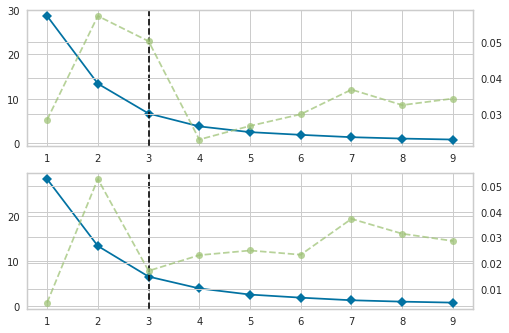

In [52]:
# 2019년
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1, 10))
plt.subplot(2, 1, 1)
visualizer.fit(set_19_sc.reshape(-1, 1))

# 2020년
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1, 10))
plt.subplot(2, 1, 2)
visualizer.fit(set_20_sc.reshape(-1, 1))

KElbowVisualizer(ax=<AxesSubplot:>,
                 estimator=KMeans(n_clusters=9, random_state=0), k=(1, 10))

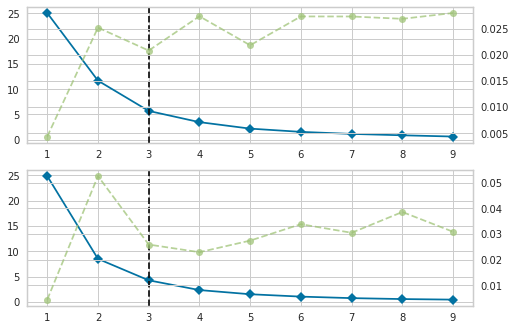

In [53]:
# 2021년
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1, 10))
plt.subplot(2, 1, 1)
visualizer.fit(set_21_sc.reshape(-1, 1))

# 2022년
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1, 10))
plt.subplot(2, 1, 2)
visualizer.fit(set_22_sc.reshape(-1, 1))

In [54]:
# 적절한 군집수 찾기 2. The Silhouette method
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):
    # from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : ' + str(n_cluster) + '\n' \
                                                                     'Silhouette Score :' + str(round(sil_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


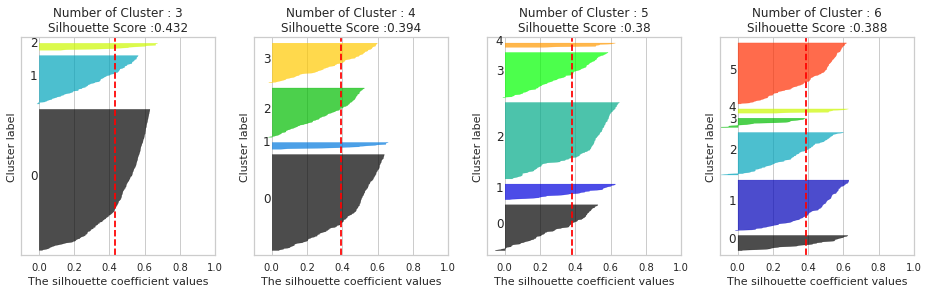

In [55]:
# 2019년
# cluster 개수를 3개, 4개, 5개, 6개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([3, 4, 5, 6], set_19_sc)

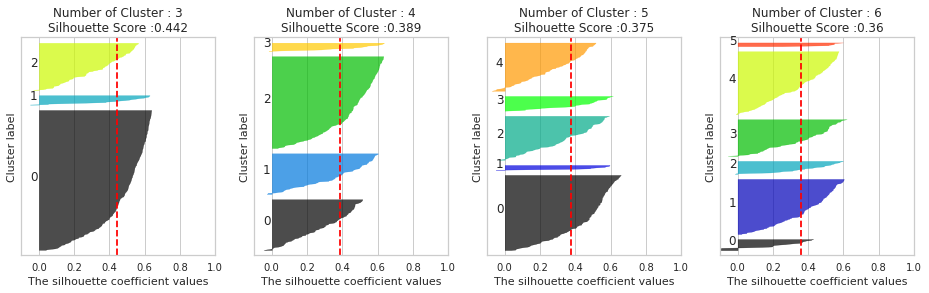

In [56]:
# 2020년
# cluster 개수를 3개, 4개, 5개, 6개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([3, 4, 5, 6], set_20_sc)

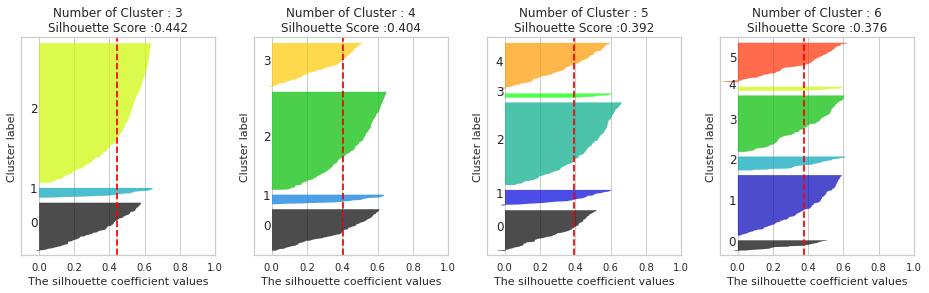

In [57]:
# 2021년
# cluster 개수를 3개, 4개, 5개, 6개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([3, 4, 5, 6], set_21_sc)

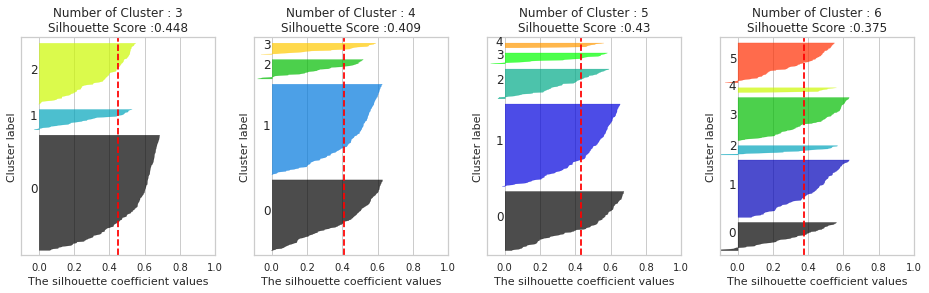

In [58]:
# 2022년
# cluster 개수를 3개, 4개, 5개, 6개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([3, 4, 5, 6], set_22_sc)

In [59]:
# 군집 수 적용
km19 = KMeans(n_clusters=4, init='k-means++', random_state=119).fit(set_19_sc)
km20 = KMeans(n_clusters=4, init='k-means++', random_state=119).fit(set_20_sc)
km21 = KMeans(n_clusters=4, init='k-means++', random_state=119).fit(set_21_sc)
km22 = KMeans(n_clusters=4, init='k-means++', random_state=119).fit(set_22_sc)

In [60]:
for_cluster19['cluster'] = km19.predict(set_19_sc)
for_cluster20['cluster'] = km20.predict(set_20_sc)
for_cluster21['cluster'] = km22.predict(set_21_sc)
for_cluster22['cluster'] = km22.predict(set_22_sc)

<ipython-input-60-6e765456c0ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_cluster19['cluster'] = km19.predict(set_19_sc)
<ipython-input-60-6e765456c0ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_cluster20['cluster'] = km20.predict(set_20_sc)
<ipython-input-60-6e765456c0ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [61]:
print(f'2019년도 군집:\n', for_cluster19['cluster'].value_counts())
print(f'\n2020년도 군집:\n', for_cluster20['cluster'].value_counts())
print(f'\n2021년도 군집:\n', for_cluster21['cluster'].value_counts())
print(f'\n2022년도 군집:\n', for_cluster22['cluster'].value_counts())

2019년도 군집:
 3    200
0    103
1     83
2     15
Name: cluster, dtype: int64

2020년도 군집:
 3    185
0    109
2     87
1     19
Name: cluster, dtype: int64

2021년도 군집:
 3    209
1     98
0     81
2     12
Name: cluster, dtype: int64

2022년도 군집:
 3    181
0    157
1     37
2     25
Name: cluster, dtype: int64


In [62]:
for_cluster19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 1597
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   code             401 non-null    int64  
 1   year             401 non-null    int64  
 2   sales per count  401 non-null    float64
 3   store density    401 non-null    float64
 4   cluster          401 non-null    int32  
dtypes: float64(2), int32(1), int64(2)
memory usage: 17.2 KB


In [63]:
new_for_cluster19 = for_cluster19.copy()
new_for_cluster20 = for_cluster20.copy()

In [64]:
new_for_cluster19.loc['cluster'] = new_for_cluster19['cluster'].astype('int64')
new_for_cluster20.loc['cluster'] = new_for_cluster20['cluster'].astype('int64')

In [65]:
def change_num_2019(num):
    if num == 3:
        return 2
    elif num == 2:
        return 3
    else:
        return num


def change_num_2020(num):
    if num == 0:
        return 3
    elif num == 3:
        return 0
    else:
        return num

In [66]:
new_for_cluster20

,code,year,sales per count,store density,cluster
1,11110515.0,2020.0,18968.0,110.000000,3.0
5,11110530.0,2020.0,22312.7,1966.333333,1.0
9,11110540.0,2020.0,23583.1,237.000000,0.0
13,11110550.0,2020.0,26928.9,67.333333,0.0
17,11110560.0,2020.0,19136.0,17.666667,3.0
...,...,...,...,...,...
1586,11740650.0,2020.0,26735.6,658.666667,0.0
1590,11740660.0,2020.0,17546.3,1395.333333,2.0
1594,11740685.0,2020.0,17257.3,804.000000,2.0
1598,11740700.0,2020.0,19218.8,205.333333,3.0


In [67]:
# 2019년 군집 번호 수정 (2번<->3번)
new_for_cluster19['cluster'] = new_for_cluster19['cluster'].apply(change_num_2019)

new_for_cluster19['cluster'].value_counts()

2.0 200
0.0 103
1.0 83
3.0 15
Name: cluster, dtype: int64

In [68]:
c_19 = new_for_cluster19.drop(['year', 'code'], axis=1)
c_20 = new_for_cluster20.drop(['year', 'code'], axis=1)
c_21 = for_cluster21.drop(['year', 'code'], axis=1)
c_22 = for_cluster22.drop(['year', 'code'], axis=1)

In [69]:
import seaborn as sns

<AxesSubplot:xlabel='sales per count', ylabel='store density'>

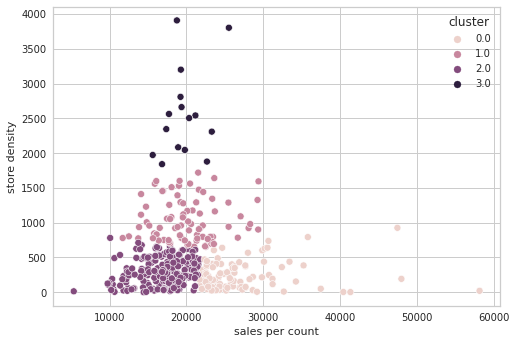

In [70]:
# (x, y) = (건당 매출 금액, 점포 밀집도) 시각화 
# 2019년
sns.scatterplot(x='sales per count', y='store density', hue='cluster', data=c_19)

<AxesSubplot:xlabel='sales per count', ylabel='store density'>

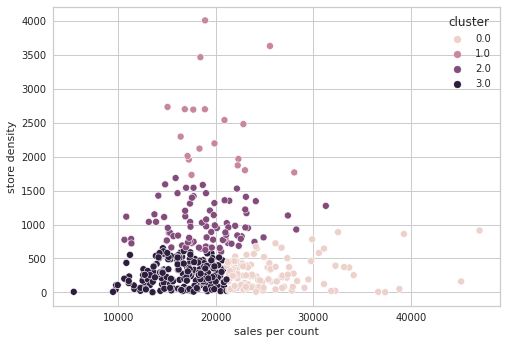

In [71]:
# 2020년
sns.scatterplot(x='sales per count', y='store density', hue='cluster', data=c_20)

<AxesSubplot:xlabel='sales per count', ylabel='store density'>

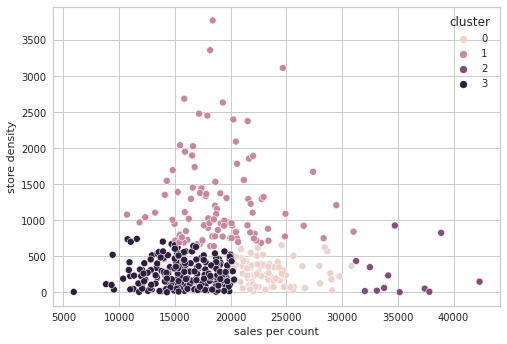

In [72]:
# 2021년
sns.scatterplot(x='sales per count', y='store density', hue='cluster', data=c_21)

<AxesSubplot:xlabel='sales per count', ylabel='store density'>

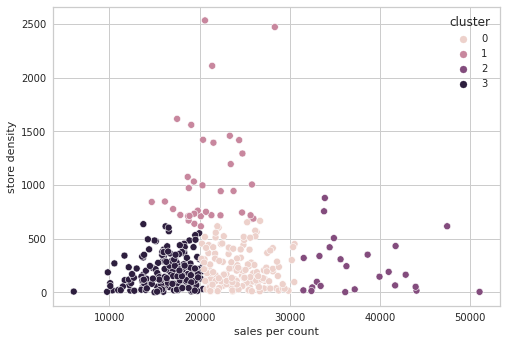

In [73]:
# 2022년
sns.scatterplot(x='sales per count', y='store density', hue='cluster', data=c_22)

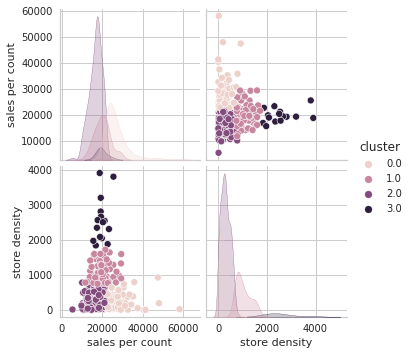

In [74]:
# 변수간 산점도 시각화 (pairplot: 데이터에 들어 있는 각 컬럼(열)들의 모든 상관 관계를 출력)
sns.pairplot(c_19, hue='cluster')
plt.show()

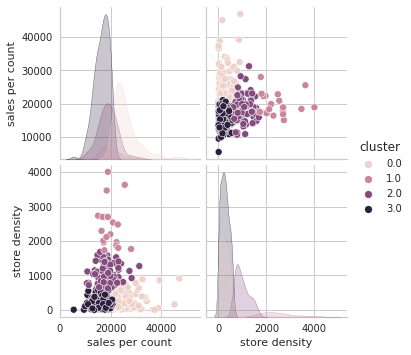

In [75]:
sns.pairplot(c_20, hue='cluster')
plt.show()

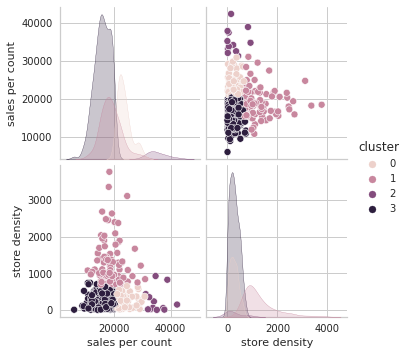

In [76]:
sns.pairplot(c_21, hue='cluster')
plt.show()

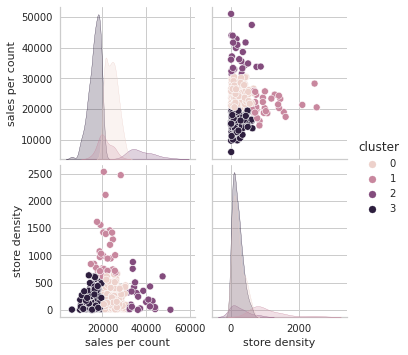

In [77]:
sns.pairplot(c_22, hue='cluster')
plt.show()

In [78]:
# 군집결과 csv 파일 output
# for_cluster19.to_csv('군집결과_2019.csv')
# for_cluster20.to_csv('군집결과_2020.csv')
# for_cluster21.to_csv('군집결과_2021.csv')
# for_cluster22.to_csv('군집결과_2022.csv')

In [79]:
#군집 결과 하나로 합치기 
_year2019 = pd.read_csv('/data/notebook_files/군집결과_2019.csv')
_year2020 = pd.read_csv('/data/notebook_files/군집결과_2020.csv')
_year2021 = pd.read_csv('/data/notebook_files/군집결과_2021.csv')
_year2022 = pd.read_csv('/data/notebook_files/군집결과_2022.csv')
# 0번 군집 : 밀집도 낮고 매출금액 평균
# 
_year_all = pd.concat([_year2019, _year2020, _year2021, _year2022])

In [80]:
_year_all

,Unnamed: 0,Unnamed: 0.1,code,year,sales per count,store density,cluster
0,0,1.0,11110515,2020,19340.9,110.000000,0
1,1,5.0,11110530,2020,22422.6,1949.750000,1
2,2,9.0,11110540,2020,24101.9,230.750000,3
3,3,13.0,11110550,2020,27129.8,65.750000,3
4,4,17.0,11110560,2020,18957.3,17.500000,0
...,...,...,...,...,...,...,...
395,1584,NaN,11740640,2022,21793.5,555.000000,0
396,1588,NaN,11740650,2022,27844.3,389.000000,0
397,1592,NaN,11740660,2022,18888.7,711.333333,1
398,1596,NaN,11740685,2022,17812.0,438.000000,3


# 연도별 군집 해석

#### 1. 2019년도
- 0번 군집: 점포 밀집도가 낮으나 매출 금액은 평균 이상인 군집 
- 1번 군집: 점포 밀집도가 높으나 매출금액은 평균에 가까운 군집
- 2번 군집: 점포 밀집도 및 매출 금액 둘다 낮은 군집 
- 3번 군집: 점포 밀집도 및 매출금액이 평균 가까이 분포되어 있는 군집 

#### 2. 2020년도 
- 0번 군집: 점포 밀집도 및 매출 금액 둘다 낮은 군집 
- 1번 군집: 점포 밀집도가 높으나 매출금액은 평균에 가까운 군집
- 2번 군집: 점포 밀집도 및 매출 금액 둘다 낮은 군집 
- 3번 군집: 점포 밀집도가 낮으나 매출 금액은 평균 이상인 군집 

#### 3. 2021년도
- 0번 군집: 점포 밀집도가 낮으면서 매출금액은 평균에 모여있는 군집 
- 1번 군집: 점포 밀집도가 평균 이상이면서 매출이 평균에 가까운 군집 
- 2번 군집: 점포 밀집도가 낮으나 매출 금액은 높은 군집 
- 3번 군집: 점포 밀집도가 낮으나 매출 금액은 평균 이하인 군집

#### 4. 2022년도
- 0번 군집: 점포 밀집도가 낮으면서 매출금액은 평균에 모여있는 군집 
- 1번 군집: 점포 밀집도가 평균 이상이면서 매출이 평균에 가까운 군집 
- 2번 군집: 점포 밀집도가 낮으나 매출 금액은 높은 군집 
- 3번 군집: 점포 밀집도가 낮으나 매출 금액은 평균 이하인 군집

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
change_ratio = pd.read_csv('/data/notebook_files/연도별 행정동 매출건수변화율 점포수변화율.csv', encoding='cp949')

In [83]:
change_ratio.rename(columns={'매출_건수_변화율':'number_sale_change',
                              '점포수_변화율':'number_store_change'}, inplace=True)
change_ratio

,Column1,행정동_코드,기준_년_코드,분기당_매출_금액,분기당_매출_건수,점포수,number_sale_change,number_store_change,행정동명
0,10,11110515,2020,1.347470e+13,7.103920e+08,56,-0.13,-0.05,청운효자동
1,20,11110515,2021,1.650110e+13,8.269980e+08,56,0.16,0.00,청운효자동
2,30,11110515,2022,2.573480e+13,1.345940e+09,31,0.63,-0.45,청운효자동
3,52,11110530,2020,3.287330e+14,1.473300e+10,483,-0.13,0.25,사직동
4,64,11110530,2021,3.227530e+14,1.491056e+10,456,0.01,-0.06,사직동
...,...,...,...,...,...,...,...,...,...
1198,2974,11740685,2021,6.845739e+10,4.381239e+06,175,-0.15,0.09,길동
1199,2975,11740685,2022,8.703796e+10,4.886490e+06,100,0.12,-0.43,길동
1200,2978,11740700,2020,1.492570e+11,7.766208e+06,63,0.11,0.00,둔촌제2동
1201,2980,11740700,2021,1.248890e+11,6.546648e+06,58,-0.16,-0.08,둔촌제2동


In [84]:
change_ratio_20 = change_ratio[change_ratio['기준_년_코드']==2020]
change_ratio_21 = change_ratio[change_ratio['기준_년_코드']==2021]
change_ratio_22 = change_ratio[change_ratio['기준_년_코드']==2022]


In [85]:
change_ratio_20.rename(columns={'분기당_매출_건수':'sales_cnt',
                       '점포수':'store_cnt'}, inplace=True)
change_ratio_21.rename(columns={'분기당_매출_건수':'sales_cnt',
                       '점포수':'store_cnt'}, inplace=True)
change_ratio_22.rename(columns={'분기당_매출_건수':'sales_cnt',
                       '점포수':'store_cnt'}, inplace=True)

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [86]:
change_ratio_20

,Column1,행정동_코드,기준_년_코드,분기당_매출_금액,sales_cnt,store_cnt,number_sale_change,number_store_change,행정동명
0,10,11110515,2020,1.347470e+13,7.103920e+08,56,-0.13,-0.05,청운효자동
3,52,11110530,2020,3.287330e+14,1.473300e+10,483,-0.13,0.25,사직동
6,95,11110540,2020,8.741350e+12,3.706616e+08,353,-0.12,-0.04,삼청동
9,119,11110550,2020,3.145710e+11,1.168155e+07,30,0.01,-0.17,부암동
12,130,11110560,2020,1.174090e+11,6.135520e+06,53,-0.12,0.04,평창동
...,...,...,...,...,...,...,...,...,...
1188,2961,11740640,2020,3.863176e+10,2.032528e+06,124,-0.04,0.00,성내제1동
1191,2965,11740650,2020,2.253810e+10,8.430010e+05,147,0.00,0.04,성내제2동
1194,2969,11740660,2020,5.963388e+10,3.398663e+06,197,0.19,0.09,성내제3동
1197,2973,11740685,2020,8.877154e+10,5.144010e+06,161,0.02,0.07,길동


<AxesSubplot:xlabel='number_store_change', ylabel='sales_cnt'>

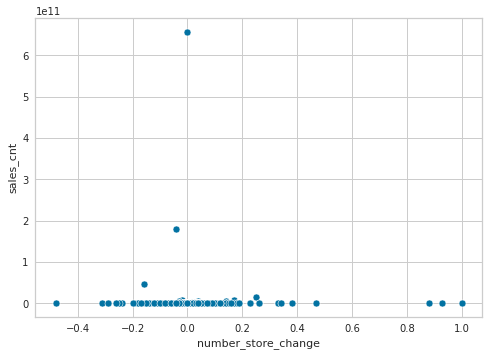

In [100]:
sns.scatterplot(x='number_store_change', y='sales_cnt', data=change_ratio_20)

<AxesSubplot:xlabel='number_sale_change', ylabel='store_cnt'>

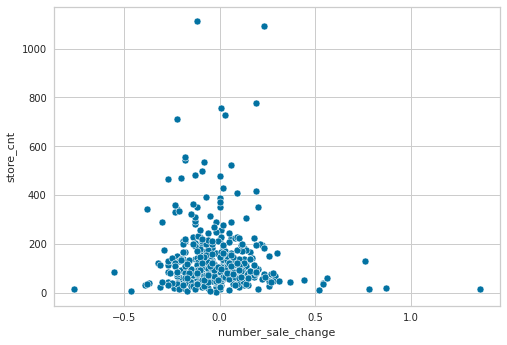

In [101]:
sns.scatterplot(x='number_sale_change', y='store_cnt', data=change_ratio_20)

<AxesSubplot:xlabel='number_sale_change', ylabel='sales_cnt'>

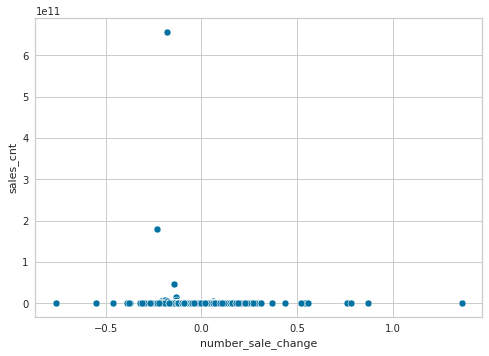

In [103]:
sns.scatterplot(x='number_sale_change', y='sales_cnt', data=change_ratio_20)

<AxesSubplot:xlabel='number_store_change', ylabel='sales_cnt'>

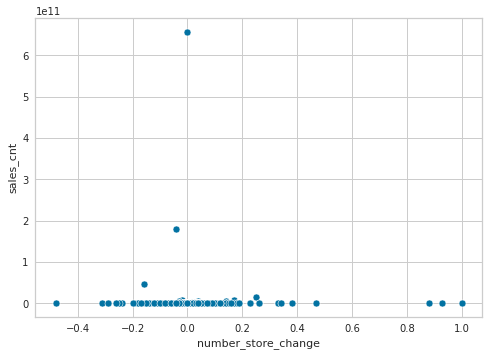

In [104]:
sns.scatterplot(x='number_store_change', y='sales_cnt', data=change_ratio_20)

<AxesSubplot:xlabel='number_sale_change', ylabel='sales_cnt'>

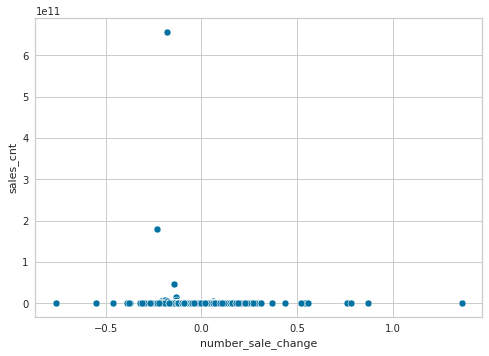

In [87]:
sns.scatterplot(x='number_sale_change', y='sales_cnt', data=change_ratio_20)

<AxesSubplot:xlabel='number_store_change', ylabel='store_cnt'>

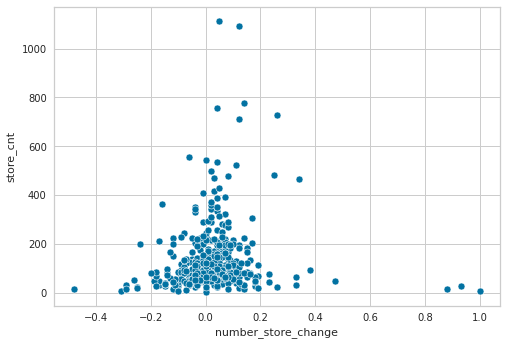

In [88]:
sns.scatterplot(x='number_store_change', y='store_cnt', data=change_ratio_20)

<AxesSubplot:xlabel='number_sale_change', ylabel='number_store_change'>

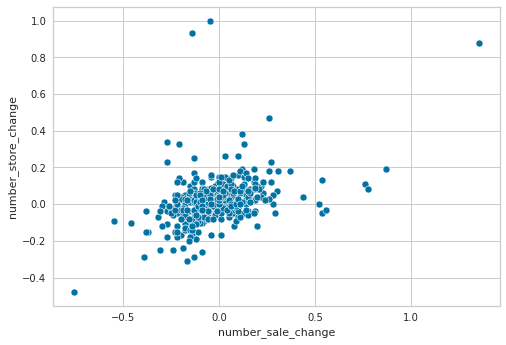

In [89]:
# 2020년
sns.set_style('whitegrid')
sns.scatterplot(x='number_sale_change', y='number_store_change', data=change_ratio_20)

<AxesSubplot:xlabel='number_sale_change', ylabel='number_store_change'>

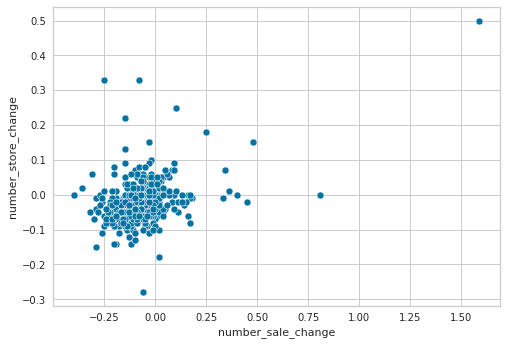

In [90]:
# 2021년
sns.set_style('whitegrid')
sns.scatterplot(x='number_sale_change', y='number_store_change', data=change_ratio_21)

<AxesSubplot:xlabel='number_sale_change', ylabel='number_store_change'>

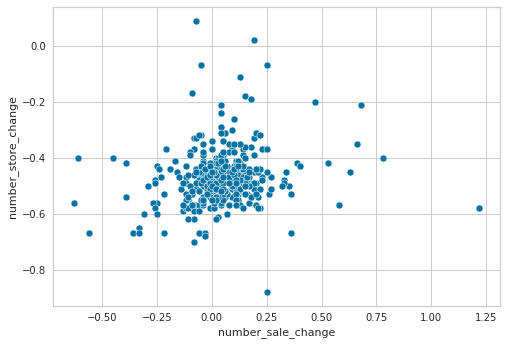

In [91]:
# 2022년
sns.set_style('whitegrid')
sns.scatterplot(x='number_sale_change', y='number_store_change', data=change_ratio_22)

# Sheet 11

In [177]:
ratio_20 = change_ratio_20[[ '행정동_코드', '기준_년_코드','store_cnt', 'number_store_change']]
ratio_21 = change_ratio_21[[ '행정동_코드', '기준_년_코드','store_cnt', 'number_store_change']]
ratio_22 = change_ratio_22[[ '행정동_코드', '기준_년_코드','store_cnt', 'number_store_change']]

In [179]:
ratio_20.rename(columns={'행정동_코드':'code',
                         '점포수':'store_cnt',
                                    '기준_년_코드':'year'}, inplace=True)
ratio_21.rename(columns={'행정동_코드':'code',
                         '점포수':'store_cnt',
                                    '기준_년_코드':'year'}, inplace=True)
ratio_22.rename(columns={'행정동_코드':'code',
                         '점포수':'store_cnt',
                                    '기준_년_코드':'year'}, inplace=True)

In [227]:
ratio_20

,code,year,store_cnt,number_store_change,cluster
0,11110515,2020,56,-0.05,0
3,11110530,2020,483,0.25,1
6,11110540,2020,353,-0.04,1
9,11110550,2020,30,-0.17,0
12,11110560,2020,53,0.04,0
...,...,...,...,...,...
1188,11740640,2020,124,0.00,0
1191,11740650,2020,147,0.04,0
1194,11740660,2020,197,0.09,0
1197,11740685,2020,161,0.07,0


In [180]:
# 데이터 정규화(Min-Max)
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [181]:
scaler = MinMaxScaler(feature_range=(0,1))

In [182]:
scaler.fit(ratio_20[['store_cnt', 'number_store_change']])
scaler.fit(ratio_21[['store_cnt', 'number_store_change']])
scaler.fit(ratio_22[['store_cnt', 'number_store_change']])

MinMaxScaler()

In [183]:
set_20_sc = scaler.transform(ratio_20[['store_cnt', 'number_store_change']])
set_21_sc = scaler.transform(ratio_21[['store_cnt', 'number_store_change']])
set_22_sc = scaler.transform(ratio_22[['store_cnt', 'number_store_change']])

In [228]:
set_20_sc

array([[7.58620690e-02, 8.55670103e-01],
 [6.64827586e-01, 1.16494845e+00],
 [4.85517241e-01, 8.65979381e-01],
 [4.00000000e-02, 7.31958763e-01],
 [7.17241379e-02, 9.48453608e-01],
 [4.41379310e-02, 8.76288660e-01],
 [7.36551724e-01, 9.48453608e-01],
 [2.55172414e-01, 8.86597938e-01],
 [7.46206897e-01, 9.07216495e-01],
 [1.61379310e-01, 8.14432990e-01],
 [1.29655172e-01, 8.14432990e-01],
 [4.74482759e-01, 9.27835052e-01],
 [1.02068966e-01, 1.01030928e+00],
 [1.57241379e-01, 8.76288660e-01],
 [4.27586207e-02, 1.24742268e+00],
 [3.17241379e-02, 6.49484536e-01],
 [8.00000000e-02, 9.48453608e-01],
 [5.02068966e-01, 7.42268041e-01],
 [2.80000000e-01, 1.08247423e+00],
 [4.56551724e-01, 8.65979381e-01],
 [4.57931034e-01, 9.48453608e-01],
 [9.79310345e-02, 9.48453608e-01],
 [2.91034483e-01, 8.86597938e-01],
 [3.07586207e-01, 1.05154639e+00],
 [9.24137931e-02, 8.65979381e-01],
 [1.77931034e-01, 9.58762887e-01],
 [6.62068966e-02, 7.31958763e-01],
 [1.07586207e-01, 1.07216495e+00],
 [1.91724138e-01, 9.89690722e-01],
 [1.44827586e-01, 8.65979381e-01],
 [8.68965517e-02, 9.07216495e-01],
 [2.24827586e-01, 9.48453608e-01],
 [1.15862069e-01, 9.17525773e-01],
 [1.82068966e-01, 1.00000000e+00],
 [2.96551724e-01, 1.01030928e+00],
 [2.41379310e-01, 9.17525773e-01],
 [9.65517241e-02, 8.14432990e-01],
 [3.36551724e-01, 8.24742268e-01],
 [6.48275862e-02, 8.86597938e-01],
 [1.71034483e-01, 9.48453608e-01],
 [2.92413793e-01, 9.58762887e-01],
 [1.06206897e-01, 8.86597938e-01],
 [4.68965517e-02, 9.69072165e-01],
 [4.73103448e-01, 8.65979381e-01],
 [2.71724138e-01, 6.59793814e-01],
 [1.29655172e-01, 9.27835052e-01],
 [3.44827586e-02, 8.04123711e-01],
 [8.82758621e-02, 1.24742268e+00],
 [8.55172414e-02, 1.03092784e+00],
 [1.90344828e-01, 8.35051546e-01],
 [8.55172414e-02, 9.07216495e-01],
 [2.68965517e-01, 1.03092784e+00],
 [3.11724138e-01, 9.69072165e-01],
 [3.72413793e-02, 7.52577320e-01],
 [3.03448276e-02, 8.65979381e-01],
 [9.24137931e-02, 8.65979381e-01],
 [1.33793103e-01, 1.02061856e+00],
 [5.51724138e-02, 1.02061856e+00],
 [8.96551724e-02, 8.45360825e-01],
 [1.90344828e-01, 8.55670103e-01],
 [2.30344828e-01, 9.89690722e-01],
 [3.08965517e-01, 7.83505155e-01],
 [6.48275862e-02, 7.11340206e-01],
 [1.51724138e-01, 9.48453608e-01],
 [3.88965517e-01, 9.69072165e-01],
 [2.95172414e-01, 9.07216495e-01],
 [8.41379310e-02, 9.07216495e-01],
 [1.03448276e-01, 8.76288660e-01],
 [1.32413793e-01, 9.89690722e-01],
 [6.75862069e-02, 9.07216495e-01],
 [2.53793103e-01, 1.00000000e+00],
 [1.15862069e-01, 9.17525773e-01],
 [1.60000000e-01, 8.96907216e-01],
 [1.20000000e-01, 9.07216495e-01],
 [8.55172414e-02, 9.79381443e-01],
 [1.17241379e-01, 8.04123711e-01],
 [2.75862069e-01, 9.58762887e-01],
 [2.48275862e-02, 1.03092784e+00],
 [1.80689655e-01, 8.65979381e-01],
 [1.44827586e-01, 9.27835052e-01],
 [7.58620690e-02, 9.48453608e-01],
 [1.14482759e-01, 8.14432990e-01],
 [9.37931034e-02, 7.21649485e-01],
 [7.31034483e-02, 1.01030928e+00],
 [8.13793103e-02, 9.79381443e-01],
 [3.53103448e-01, 9.48453608e-01],
 [2.34482759e-01, 9.38144330e-01],
 [3.17241379e-02, 1.17525773e+00],
 [2.99310345e-01, 9.27835052e-01],
 [1.03448276e-01, 8.96907216e-01],
 [1.90344828e-01, 8.35051546e-01],
 [2.05517241e-01, 7.83505155e-01],
 [1.93103448e-02, 7.83505155e-01],
 [2.49655172e-01, 1.06185567e+00],
 [1.33793103e-01, 8.86597938e-01],
 [1.02068966e-01, 9.07216495e-01],
 [1.76551724e-01, 1.02061856e+00],
 [1.55862069e-01, 8.76288660e-01],
 [1.94482759e-01, 9.38144330e-01],
 [9.24137931e-02, 1.01030928e+00],
 [2.40000000e-01, 9.58762887e-01],
 [1.06206897e-01, 8.45360825e-01],
 [6.06896552e-02, 8.86597938e-01],
 [6.48275862e-02, 1.00000000e+00],
 [1.80689655e-01, 8.65979381e-01],
 [1.48965517e-01, 9.27835052e-01],
 [3.44827586e-02, 1.09278351e+00],
 [1.13103448e-01, 9.69072165e-01],
 [4.96551724e-02, 8.04123711e-01],
 [4.13793103e-02, 9.38144330e-01],
 [1.86206897e-01, 8.35051546e-01],
 [3.98620690e-01, 9.27835052e-01],
 [1.95862069e-01, 8.86597938e-01],
 [7.72413793e-02, 9.69072165e-01],
 [1.

In [184]:
!pip install yellowbrick

In [185]:
# 적절한 군집수 찾기 1. The Elbow method
from yellowbrick.cluster import KElbowVisualizer

KElbowVisualizer(ax=<AxesSubplot:>,
                 estimator=KMeans(n_clusters=9, random_state=0), k=(1, 10))

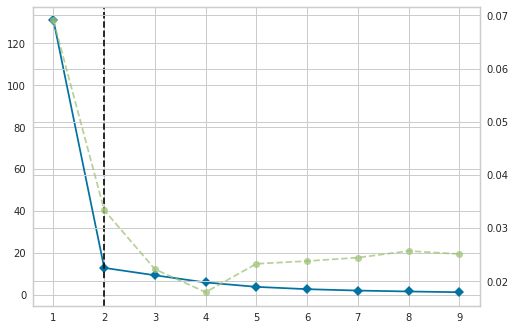

In [186]:
# 2020년
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k = (1,10))
visualizer.fit(set_20_sc.reshape(-1,1))

KElbowVisualizer(ax=<AxesSubplot:>,
                 estimator=KMeans(n_clusters=9, random_state=0), k=(1, 10))

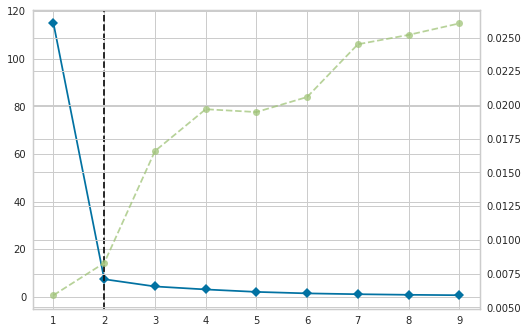

In [187]:
# 2021년
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k = (1,10))
visualizer.fit(set_21_sc.reshape(-1,1))

KElbowVisualizer(ax=<AxesSubplot:>,
                 estimator=KMeans(n_clusters=9, random_state=0), k=(1, 10))

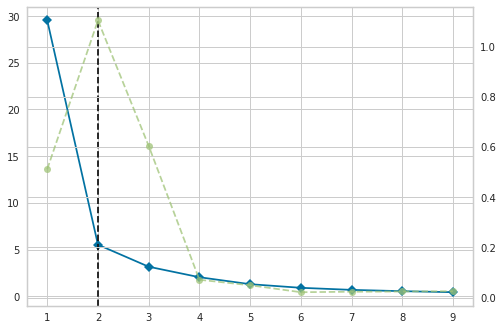

In [189]:
# 2022년
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k = (1,10))
visualizer.fit(set_22_sc.reshape(-1,1))

In [190]:
# 적절한 군집수 찾기 2. The Silhouette method
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    # from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

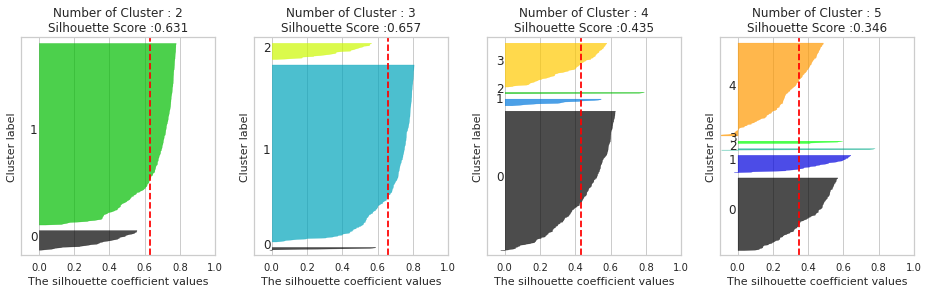

In [191]:
# 2020년
# cluster 개수를 3개, 4개, 5개, 6개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([2, 3, 4, 5], set_20_sc)

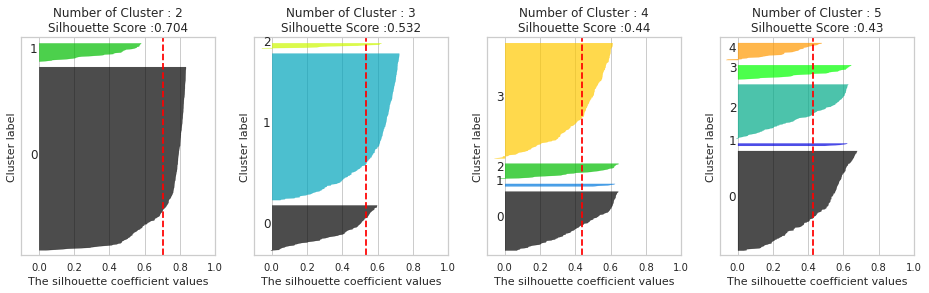

In [192]:
# 2021년
# cluster 개수를 3개, 4개, 5개, 6개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([2, 3, 4, 5], set_21_sc)

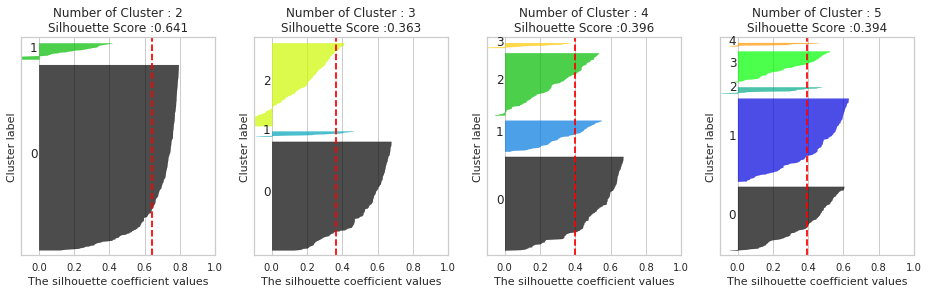

In [193]:
# 2022년
# cluster 개수를 3개, 4개, 5개, 6개 일때의 클러스터별 실루엣 계수 평균값을 시각화 
visualize_silhouette([2, 3, 4, 5], set_22_sc)

In [196]:
# 군집수 적용
km20 = KMeans(n_clusters=3, init='k-means++', random_state=119).fit(set_20_sc)
ratio_20['cluster'] = km20.predict(set_20_sc)

km21 = KMeans(n_clusters=3, init='k-means++', random_state=119).fit(set_21_sc)
ratio_21['cluster'] = km21.predict(set_21_sc)

km22 = KMeans(n_clusters=4, init='k-means++', random_state=119).fit(set_22_sc)
ratio_22['cluster'] = km22.predict(set_22_sc)

<ipython-input-196-ac72f8eb5f08>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_20['cluster'] = km20.predict(set_20_sc)
<ipython-input-196-ac72f8eb5f08>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_21['cluster'] = km21.predict(set_21_sc)
<ipython-input-196-ac72f8eb5f08>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [197]:
c_20 = ratio_20.drop(['year', 'code'], axis=1)
c_21 = ratio_21.drop(['year', 'code'], axis=1)
c_22 = ratio_22.drop(['year', 'code'], axis=1)

[Text(0.5, 1.0, '2020Y')]

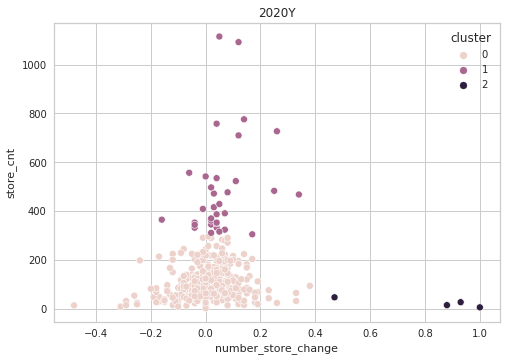

In [198]:
# 2020년
sct_2020 = sns.scatterplot(x='number_store_change', y='store_cnt', hue='cluster', data=c_20)
sct_2020.set(title = "2020Y")

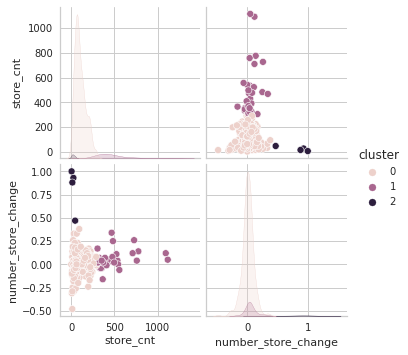

In [202]:
# 2020Y
sns.pairplot(c_20, hue = 'cluster')
plt.show()

[Text(0.5, 1.0, '2021Y')]

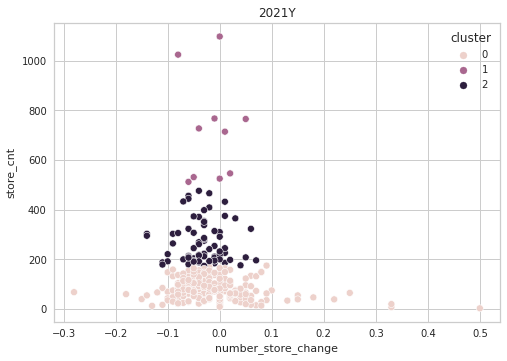

In [199]:
# 2021년
sct_2021 = sns.scatterplot(x='number_store_change', y='store_cnt', hue='cluster', data=c_21)
sct_2021.set(title = "2021Y")

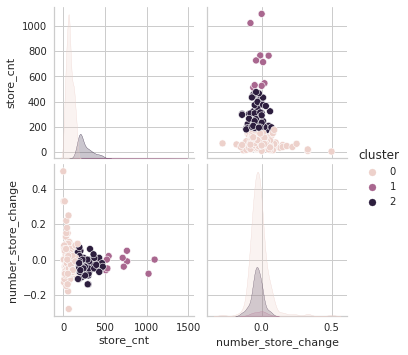

In [203]:
# 2021Y
sns.pairplot(c_21, hue = 'cluster')
plt.show()

[Text(0.5, 1.0, '2022Y')]

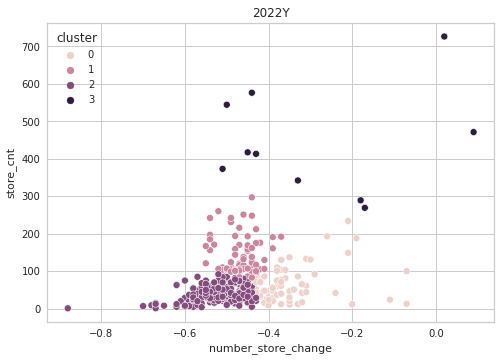

In [200]:
# 2022년
sct_2022 = sns.scatterplot(x='number_store_change', y='store_cnt', hue='cluster', data=c_22)
sct_2022.set(title = "2022Y")

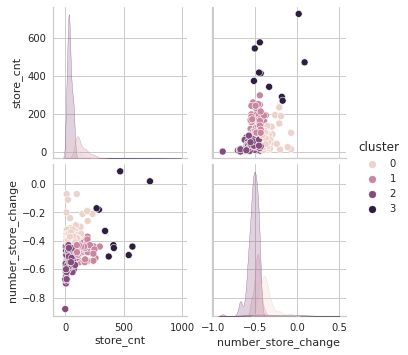

In [204]:
# 2022Y
sns.pairplot(c_22, hue = 'cluster')
plt.show()

# Sheet 12

In [96]:
ratio_20 = change_ratio_20[[ '행정동_코드', '기준_년_코드','store_cnt', 'number_store_change']]
ratio_21 = change_ratio_21[[ '행정동_코드', '기준_년_코드','store_cnt', 'number_store_change']]
ratio_22 = change_ratio_22[[ '행정동_코드', '기준_년_코드','store_cnt', 'number_store_change']]

In [97]:
ratio_20.rename(columns={'행정동_코드':'code',
                         '점포수':'store_cnt',
                                    '기준_년_코드':'year'}, inplace=True)
ratio_21.rename(columns={'행정동_코드':'code',
                         '점포수':'store_cnt',
                                    '기준_년_코드':'year'}, inplace=True)
ratio_22.rename(columns={'행정동_코드':'code',
                         '점포수':'store_cnt',
                                    '기준_년_코드':'year'}, inplace=True)

/opt/python/envs/default/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [98]:
# 데이터 정규화(Min-Max)
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [99]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
scaler.fit(ratio_20[['store_cnt', 'number_store_change']])
scaler.fit(ratio_21[['store_cnt', 'number_store_change']])
scaler.fit(ratio_22[['store_cnt', 'number_store_change']])

# 색깔맞추기

In [388]:
import matplotlib.pyplot as plt

In [389]:
area_df

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934,438813,11545,11545710,NaN
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265,459431,11350,11350611,NaN
2,202112,A,골목상권,2110755,동일여자고등학교,192300,439070,11545,11545680,NaN
3,202112,A,골목상권,2110739,시흥3동 우편취급국,191289,438014,11545,11545690,NaN
4,202112,A,골목상권,2111017,송파나루역 3번,210222,445516,11710,11710562,NaN
...,...,...,...,...,...,...,...,...,...,...
1666,202112,U,관광특구,1001493,동대문패션타운 관광특구,200974,451975,11140,11140590,NaN
1667,202112,U,관광특구,1001494,종로?청계 관광특구,199768,452273,11110,11110615,NaN
1668,202112,U,관광특구,1001495,잠실 관광특구,210191,446339,11710,11710566,NaN
1669,202112,U,관광특구,1001496,강남 마이스 관광특구,205310,445727,11680,11680580,NaN


In [390]:
kt_demo_list = demand_factors_df[demand_factors_df['총_생활인구_수'] == 0]['상권_코드'].unique().tolist()

In [391]:
for i in kt_demo_list:
    print(area_df[area_df['상권_코드'] == i]['상권_코드_명'])

1619    남평화시장
Name: 상권_코드_명, dtype: object
1387    제일평화시장
Name: 상권_코드_명, dtype: object
157    헌인가구단지
Name: 상권_코드_명, dtype: object
98    청계산원터골
Name: 상권_코드_명, dtype: object


In [392]:
reside_list = demand_factors_df[demand_factors_df['총 상주인구 수'] == 0]['상권_코드'].sort_index(
    ascending=True).unique().tolist()

for i in reside_list:
    print(area_df[area_df['상권_코드'] == i][['상권_코드', '상권_코드_명']])

        상권_코드   상권_코드_명
1545  2130008  종오지하쇼핑센터
        상권_코드                상권_코드_명
1494  2130028  을지입구지하상가(을지로지하보도쇼핑센터)
        상권_코드   상권_코드_명
1439  2130184  마포농수산물시장
        상권_코드 상권_코드_명
1423  2130174   연희사러가
        상권_코드         상권_코드_명
1590  2130298  강남터미널지하도상점가2구역
        상권_코드         상권_코드_명
1524  2130022  숭례문수입상가(남대문시장)
        상권_코드      상권_코드_명
1481  2130044  에리어식스(벨포스트)
        상권_코드          상권_코드_명
1284  2120099  월드컵경기장역(월드컵경기장)
        상권_코드     상권_코드_명
1377  2130006  종로4가지하쇼핑센터
        상권_코드   상권_코드_명
1648  2130029  명동역지하도상가
        상권_코드                        상권_코드_명
1623  2130156  시영2단지 무지개종합상가(중계 무지개2단지아파트상가)
        상권_코드                상권_코드_명
1375  2130030  을지로지하보도쇼핑센터(을지입구지하상가)
        상권_코드      상권_코드_명
1330  2120115  김포공항역(김포공항)
        상권_코드 상권_코드_명
1177  2120231    가락시장
        상권_코드              상권_코드_명
1505  2130041  신평화패션타운(청계6가 지하도상가)
        상권_코드              상권_코드_명
1476  2130027  명동지하쇼핑센터(소공동지하쇼핑센터)
        상권_코드 상권_코드_명
1624  2130045   광희패션몰
    

In [393]:
demand_factors_df[demand_factors_df['총 상주인구 수'] == 0]['상권_코드'].sort_values(ascending=True).unique().tolist()

[2110443,
 2111002,
 2120025,
 2120074,
 2120099,
 2120115,
 2120137,
 2120231,
 2130003,
 2130006,
 2130008,
 2130009,
 2130022,
 2130023,
 2130025,
 2130026,
 2130027,
 2130028,
 2130029,
 2130030,
 2130037,
 2130040,
 2130041,
 2130043,
 2130044,
 2130045,
 2130096,
 2130142,
 2130155,
 2130156,
 2130174,
 2130184,
 2130215,
 2130239,
 2130248,
 2130251,
 2130252,
 2130259,
 2130289,
 2130297,
 2130298,
 2130299,
 2130300,
 2130304,
 2130309]

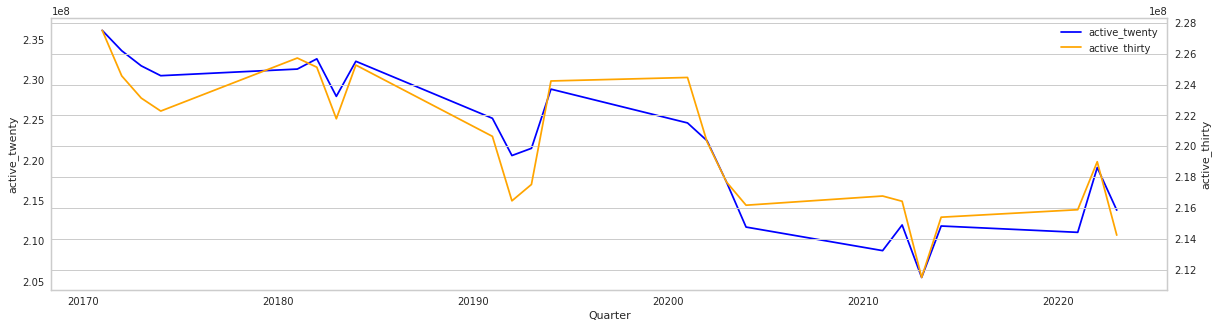

In [394]:
fig, ax1 = plt.subplots(figsize=(20, 5))

ax2 = ax1.twinx()
lns1 = ax1.plot(quarter_demand_df['기준_년분기_코드'], quarter_demand_df['연령대_20_생활인구_수'], label='active_twenty', color='blue')
lns2 = ax2.plot(quarter_demand_df['기준_년분기_코드'], quarter_demand_df['연령대_30_생활인구_수'], label='active_thirty',
                color='orange')
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.grid()
ax1.set_xlabel('Quarter')
ax1.set_ylabel('active_twenty')
ax2.set_ylabel('active_thirty')
plt.show()

In [395]:
#군집 결과 하나로 합치기 
_year2019 = pd.read_csv('/data/notebook_files/군집결과_2019.csv')
_year2020 = pd.read_csv('/data/notebook_files/군집결과_2020.csv')
_year2021 = pd.read_csv('/data/notebook_files/군집결과_2021.csv')
_year2022 = pd.read_csv('/data/notebook_files/군집결과_2022.csv')
# 0번 군집 : 밀집도 낮고 매출금액 평균
# 
_year_all = pd.concat([_year2019, _year2020, _year2021, _year2022])

In [396]:
_year2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       400 non-null    int64  
 1   Unnamed: 0.1     400 non-null    int64  
 2   code             400 non-null    int64  
 3   year             400 non-null    int64  
 4   sales per count  400 non-null    float64
 5   store density    400 non-null    float64
 6   cluster          400 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 22.0 KB


In [397]:
# _year2019['cluster'] = _year2019['cluster'].astype(str)
# _year2020['cluster'] = _year2020['cluster'].astype(str)

In [398]:
# _year2019['cluster'] = _year2019['cluster'].replace('2', 'a')

In [399]:
# _year2019['cluster'] = _year2019['cluster'].replace('3', 'b')

In [400]:
# _year2019['cluster'] = _year2019['cluster'].replace('0', 'a')
# _year2019['cluster'] = _year2019['cluster'].replace('3', 'b')

In [401]:
# _year2019['cluster'] = _year2019['cluster'].replace('a', '3')
# _year2019['cluster'] = _year2019['cluster'].replace('b', '0')

In [402]:
# _year2020['cluster'] = _year2020['cluster'].replace('0', 'a')
# _year2020['cluster'] = _year2020['cluster'].replace('3', 'b')

In [403]:
# _year2020['cluster'] = _year2020['cluster'].replace('a', '3')
# _year2020['cluster'] = _year2020['cluster'].replace('b', '0')

In [404]:
type(_year2019['cluster'][0])

numpy.int64

In [405]:
_year2019['cluster'].value_counts()

0 195
3 97
2 89
1 19
Name: cluster, dtype: int64

In [406]:
_year2020['cluster'].value_counts()

0 195
3 97
2 89
1 19
Name: cluster, dtype: int64

In [407]:
# _year_all = pd.concat([_year2019,_year2020,_year2021,_year2022])

In [408]:
# _year_all.to_csv('clustering_year_all.csv')

In [409]:
# _year2019.to_csv('군집결과_2019.csv')
# _year2020.to_csv('군집결과_2019.csv')

# 수요특성

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# 상권별데이터_쓸것1.csv 에서 다음 작업 후 수요특성.csv 파일을 만들어서 불러왔음

In [14]:
"""
def week_pop(df):
    week_list = ['월요일_생활인구_수',
                 '화요일_생활인구_수',
                 '수요일_생활인구_수',
                 '목요일_생활인구_수',
                 '금요일_생활인구_수', ]
    # print(df)
    return df[week_list].sum()


def weekend_pop(df):
    weekend_list = ['토요일_생활인구_수',
                    '일요일_생활인구_수', ]
    # print(df)
    return df[weekend_list].sum()


def percent2030always(df):
    divide = '총 상주인구 수'
    sums = ['연령대 20 상주인구 수',
            '연령대 30 상주인구 수', ]
    return np.sum(df[sums]) / df[divide]



def percent2030living(df):
    divide =   '총_생활인구_수'
    sums = ['연령대_20_생활인구_수',
            '연령대_30_생활인구_수', ]
    return np.sum(df[sums]) / df[divide]
"""

"\ndef week_pop(df):\n    week_list = ['월요일_생활인구_수',\n                 '화요일_생활인구_수',\n                 '수요일_생활인구_수',\n                 '목요일_생활인구_수',\n                 '금요일_생활인구_수', ]\n    # print(df)\n    return df[week_list].sum()\n\n\ndef weekend_pop(df):\n    weekend_list = ['토요일_생활인구_수',\n                    '일요일_생활인구_수', ]\n    # print(df)\n    return df[weekend_list].sum()\n\n\ndef percent2030always(df):\n    divide = '총 상주인구 수'\n    sums = ['연령대 20 상주인구 수',\n            '연령대 30 상주인구 수', ]\n    return np.sum(df[sums]) / df[divide]\n\n\n\ndef percent2030living(df):\n    divide =   '총_생활인구_수'\n    sums = ['연령대_20_생활인구_수',\n            '연령대_30_생활인구_수', ]\n    return np.sum(df[sums]) / df[divide]\n"

In [15]:
"""
data1['주중인구'] = data1.T.apply(week_pop)

data1['주말인구'] = data1.T.apply(weekend_pop)

data1['2030생활인구_비중']=data1.T.apply(percent2030living)

data1['2030상주인구_비중'] = data1.T.apply(percent2030always)
"""

"\ndata1['주중인구'] = data1.T.apply(week_pop)\n\ndata1['주말인구'] = data1.T.apply(weekend_pop)\n\ndata1['2030생활인구_비중']=data1.T.apply(percent2030living)\n\ndata1['2030상주인구_비중'] = data1.T.apply(percent2030always)\n"

In [16]:
# 상권별 수요특성 컬럼 병합 데이터프레임

demand_factor_df = pd.read_csv('/data/notebook_files/수요특성.csv')
demand_factor_df.drop('Unnamed: 0', axis=1, inplace=True)
demand_factor_df.head()

,기준_년_코드,기준_분기_코드,상권_코드,총 가구 수,총 상주인구 수,연령대 20 상주인구 수,연령대 30 상주인구 수,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,...,화요일_생활인구_수,수요일_생활인구_수,목요일_생활인구_수,금요일_생활인구_수,토요일_생활인구_수,일요일_생활인구_수,주중인구,주말인구,2030생활인구_비중,2030상주인구_비중
0,2022,3,2110633,238.0,460.0,79.0,85.0,45644.0,4083.0,7224.0,...,6158.0,6218.0,6204.0,6262.0,7210.0,7367.0,31067.0,14577.0,0.247721,0.356522
1,2022,3,2130104,312.0,595.0,64.0,61.0,76310.0,8664.0,11154.0,...,10888.0,10700.0,10624.0,10674.0,11037.0,11517.0,53755.0,22554.0,0.259704,0.210084
2,2022,3,2110957,1088.0,1761.0,300.0,454.0,959048.0,192354.0,262575.0,...,157657.0,159181.0,157320.0,148054.0,98709.0,91380.0,768958.0,190089.0,0.474355,0.428166
3,2022,3,2110435,146.0,291.0,68.0,30.0,67832.0,17038.0,8889.0,...,10273.0,10323.0,10122.0,9713.0,8657.0,8853.0,50320.0,17510.0,0.382224,0.336770
4,2022,3,2110055,224.0,302.0,70.0,74.0,404571.0,57960.0,95926.0,...,56965.0,57191.0,56713.0,56919.0,59738.0,59472.0,285361.0,119210.0,0.380368,0.476821


In [17]:
# 상권_코드, 행정동_코드 데이터 프레임

hj_area_df = pd.read_csv('/data/notebook_files/(상권영역).csv', encoding='cp949')
hj_area_df = hj_area_df[['상권_코드', '행정동_코드']]
hj_area_df

,상권_코드,행정동_코드
0,2110753,11545710
1,2110427,11350611
2,2110755,11545680
3,2110739,11545690
4,2111017,11710562
...,...,...
1666,1001493,11140590
1667,1001494,11110615
1668,1001495,11710566
1669,1001496,11680580


In [18]:
# 수요특성 데이터프레임에 행정동_코드 붙이기

demand_factors_df = pd.merge(demand_factor_df, hj_area_df, how='left', on='상권_코드')
demand_factors_df.isna().sum()

기준_년_코드 0
기준_분기_코드 0
상권_코드 0
총 가구 수 0
총 상주인구 수 0
연령대 20 상주인구 수 0
연령대 30 상주인구 수 0
총_생활인구_수 0
연령대_20_생활인구_수 0
연령대_30_생활인구_수 0
아파트_평균_시가 0
총_직장_인구_수 0
월요일_생활인구_수 0
화요일_생활인구_수 0
수요일_생활인구_수 0
목요일_생활인구_수 0
금요일_생활인구_수 0
토요일_생활인구_수 0
일요일_생활인구_수 0
주중인구 0
주말인구 0
2030생활인구_비중 62
2030상주인구_비중 885
행정동_코드 0
dtype: int64

In [19]:
# 2030상주인구_비중, 2030생활인구_비중 열 제외

# temp = demand_factors_df.loc[:, (demand_factors_df.columns != '2030생활인구_비중')& (demand_factors_df.columns != '2030상주인구_비중')]

In [20]:
# 행정동 단위 groupby, 아파트_시가_평균 은 mean()으로, 나머지는 sum()으로

# temp_hj_sum = temp.groupby(['기준_년_코드','기준_분기_코드','행정동_코드'])[['총 가구 수','총 상주인구 수','연령대 20 상주인구 수','연령대 30 상주인구 수','총_생활인구_수','연령대_20_생활인구_수','연령대_30_생활인구_수','총_직장_인구_수','주중인구','주말인구']].sum().reset_index()
# temp_hj_mean = temp.groupby(['기준_년_코드','기준_분기_코드','행정동_코드'])[['아파트_평균_시가']].mean().reset_index()

# 행정동 단위 groupby dataframe

In [21]:
# 행정동 단위 groupby

dong_demand_sum_df = demand_factors_df.groupby(['기준_년_코드', '기준_분기_코드', '행정동_코드'])[
    ['총 가구 수', '총 상주인구 수', '연령대 20 상주인구 수', '연령대 30 상주인구 수', '총_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '총_직장_인구_수',
     '주중인구', '주말인구']].sum().reset_index()
dong_demand_mean_df = demand_factors_df.groupby(['기준_년_코드', '기준_분기_코드', '행정동_코드'])[['아파트_평균_시가']].mean().reset_index()
dong_demand_df = pd.merge(dong_demand_sum_df, dong_demand_mean_df, how='inner', on=['기준_년_코드', '기준_분기_코드', '행정동_코드'])

dong_demand_df.head()

,기준_년_코드,기준_분기_코드,행정동_코드,총 가구 수,총 상주인구 수,연령대 20 상주인구 수,연령대 30 상주인구 수,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,총_직장_인구_수,주중인구,주말인구,아파트_평균_시가
0,2017,1,11110515,3699.0,8794.0,1087.0,1314.0,1837512.0,265308.0,307903.0,0.0,1319638.0,517875.0,2.531570e+08
1,2017,1,11110530,4491.0,10101.0,1303.0,1577.0,4512158.0,786742.0,906233.0,0.0,3454826.0,1057331.0,3.183742e+08
2,2017,1,11110540,629.0,1324.0,164.0,210.0,182059.0,34488.0,34186.0,0.0,131561.0,50496.0,3.539464e+08
3,2017,1,11110550,3409.0,8320.0,1244.0,1030.0,732224.0,89809.0,82196.0,0.0,520574.0,211651.0,1.956186e+08
4,2017,1,11110560,3163.0,7785.0,1126.0,921.0,620417.0,69045.0,66068.0,0.0,437554.0,182860.0,3.867052e+08


In [22]:
# 서울시 법정동, 행정동 코드정보 
seoul_df = pd.read_csv('/data/notebook_files/서울시 건축물대장 법정동,행정동 코드정보.csv', )

In [23]:
dong_demand_df[dong_demand_df['총_생활인구_수'] == 0]

,기준_년_코드,기준_분기_코드,행정동_코드,총 가구 수,총 상주인구 수,연령대 20 상주인구 수,연령대 30 상주인구 수,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,총_직장_인구_수,주중인구,주말인구,아파트_평균_시가


In [25]:
# 2030생활&상주인구 비중, 주말 대비 주중 생활인구 비중 함수

def percent2030always(df):
    divide = '총 상주인구 수'
    sums = ['연령대 20 상주인구 수',
            '연령대 30 상주인구 수', ]
    return np.sum(df[sums]) / df[divide]


def percent2030living(df):
    divide = '총_생활인구_수'
    sums = ['연령대_20_생활인구_수',
            '연령대_30_생활인구_수', ]
    return np.sum(df[sums]) / df[divide]


def percentweek(df):
    weekend = '주말인구'
    weekdays = '주중인구'
    return df[weekdays] / (df[weekend] + df[weekdays])

In [26]:
# 2030생활&상주인구 비중, 주말 대비 주중 생활인구 비중 컬럼 추가

dong_demand_df['2030생활인구_비중'] = round(dong_demand_df.T.apply(percent2030living), 2)

dong_demand_df['2030상주인구_비중'] = round(dong_demand_df.T.apply(percent2030always), 2)

dong_demand_df['주중_생활인구_비중'] = round(dong_demand_df.T.apply(percentweek), 2)

<ipython-input-25-8d6488b2e7a3>:7: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(df[sums]) / df[divide]


In [27]:
# 수요특성 데이터프레임에서 2017년도, 2018년도 제거

dong_demand_df.drop(dong_demand_df[dong_demand_df['기준_년_코드'] == 2017].index, inplace=True)
dong_demand_df.drop(dong_demand_df[dong_demand_df['기준_년_코드'] == 2018].index, inplace=True)

In [28]:
# 수요특성 데이터프레임에서 2019~2021년도 4분기 제거

dong_demand_df.drop(dong_demand_df[dong_demand_df['기준_분기_코드'] == 4].index, inplace=True)

In [29]:
dong_demand_df

,기준_년_코드,기준_분기_코드,행정동_코드,총 가구 수,총 상주인구 수,연령대 20 상주인구 수,연령대 30 상주인구 수,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,총_직장_인구_수,주중인구,주말인구,아파트_평균_시가,2030생활인구_비중,2030상주인구_비중,주중_생활인구_비중
3216,2019,1,11110515,3546.0,8315.0,1023.0,1180.0,1645152.0,224876.0,251566.0,1441.0,1184376.0,460774.0,2.587801e+08,0.29,0.26,0.72
3217,2019,1,11110530,4443.0,9520.0,1214.0,1492.0,3846752.0,624806.0,751857.0,88899.0,2926831.0,919927.0,2.874831e+08,0.36,0.28,0.76
3218,2019,1,11110540,628.0,1286.0,156.0,226.0,182612.0,27413.0,32972.0,1238.0,132940.0,49672.0,4.237381e+08,0.33,0.30,0.73
3219,2019,1,11110550,3365.0,7999.0,1173.0,1008.0,739933.0,90720.0,83720.0,1029.0,524820.0,215113.0,1.733013e+08,0.24,0.27,0.71
3220,2019,1,11110560,3230.0,7647.0,1170.0,867.0,531777.0,53980.0,59265.0,1347.0,377569.0,154209.0,4.151333e+08,0.21,0.27,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9241,2022,3,11740640,5261.0,12129.0,1755.0,2083.0,4039442.0,490006.0,639261.0,11831.0,2966744.0,1072711.0,2.178569e+08,0.28,0.32,0.73
9242,2022,3,11740650,10561.0,19640.0,3291.0,3344.0,7339960.0,984599.0,1260173.0,1260.0,5167283.0,2172675.0,1.888666e+08,0.31,0.34,0.70
9243,2022,3,11740660,9136.0,20085.0,3066.0,3093.0,6820208.0,908722.0,1019447.0,3709.0,4835668.0,1984540.0,2.101294e+08,0.28,0.31,0.71
9244,2022,3,11740685,16697.0,33999.0,5663.0,5512.0,12547761.0,1558513.0,1928969.0,8779.0,8911884.0,3635877.0,2.432761e+08,0.28,0.33,0.71


In [30]:
dong_demand_df['기준_년_코드'].value_counts()

2019 1206
2020 1206
2021 1206
2022 1206
Name: 기준_년_코드, dtype: int64

In [31]:
dong_demand_df.to_csv('dong_demand.csv')

In [32]:
dong_demand_df

,기준_년_코드,기준_분기_코드,행정동_코드,총 가구 수,총 상주인구 수,연령대 20 상주인구 수,연령대 30 상주인구 수,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,총_직장_인구_수,주중인구,주말인구,아파트_평균_시가,2030생활인구_비중,2030상주인구_비중,주중_생활인구_비중
3216,2019,1,11110515,3546.0,8315.0,1023.0,1180.0,1645152.0,224876.0,251566.0,1441.0,1184376.0,460774.0,2.587801e+08,0.29,0.26,0.72
3217,2019,1,11110530,4443.0,9520.0,1214.0,1492.0,3846752.0,624806.0,751857.0,88899.0,2926831.0,919927.0,2.874831e+08,0.36,0.28,0.76
3218,2019,1,11110540,628.0,1286.0,156.0,226.0,182612.0,27413.0,32972.0,1238.0,132940.0,49672.0,4.237381e+08,0.33,0.30,0.73
3219,2019,1,11110550,3365.0,7999.0,1173.0,1008.0,739933.0,90720.0,83720.0,1029.0,524820.0,215113.0,1.733013e+08,0.24,0.27,0.71
3220,2019,1,11110560,3230.0,7647.0,1170.0,867.0,531777.0,53980.0,59265.0,1347.0,377569.0,154209.0,4.151333e+08,0.21,0.27,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9241,2022,3,11740640,5261.0,12129.0,1755.0,2083.0,4039442.0,490006.0,639261.0,11831.0,2966744.0,1072711.0,2.178569e+08,0.28,0.32,0.73
9242,2022,3,11740650,10561.0,19640.0,3291.0,3344.0,7339960.0,984599.0,1260173.0,1260.0,5167283.0,2172675.0,1.888666e+08,0.31,0.34,0.70
9243,2022,3,11740660,9136.0,20085.0,3066.0,3093.0,6820208.0,908722.0,1019447.0,3709.0,4835668.0,1984540.0,2.101294e+08,0.28,0.31,0.71
9244,2022,3,11740685,16697.0,33999.0,5663.0,5512.0,12547761.0,1558513.0,1928969.0,8779.0,8911884.0,3635877.0,2.432761e+08,0.28,0.33,0.71


In [33]:
dong_demand_df.columns

Index(['기준_년_코드', '기준_분기_코드', '행정동_코드', '총 가구 수', '총 상주인구 수', '연령대 20 상주인구 수',
       '연령대 30 상주인구 수', '총_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수',
       '총_직장_인구_수', '주중인구', '주말인구', '아파트_평균_시가', '2030생활인구_비중', '2030상주인구_비중',
       '주중_생활인구_비중'],
      dtype='object')

# divide_cluster

In [513]:
all_cluster = pd.read_csv("/data/notebook_files/_year_all.csv")
all_cluster

,Unnamed: 0,code,year,sales per count,store density,cluster
0,0,11110515,2019,18081.8,115.500000,3
1,4,11110530,2019,22891.8,1914.500000,1
2,8,11110540,2019,25632.6,252.000000,0
3,12,11110550,2019,25802.1,79.000000,0
4,16,11110560,2019,17885.8,17.750000,3
...,...,...,...,...,...,...
1596,1584,11740640,2022,21793.5,555.000000,0
1597,1588,11740650,2022,27844.3,389.000000,0
1598,1592,11740660,2022,18888.7,711.333333,1
1599,1596,11740685,2022,17812.0,438.000000,3


In [540]:
cluster_19 = all_cluster[all_cluster['year'] == 2019]

cluster_0_19_df = cluster_19[cluster_19['cluster'] == 0].iloc[:, 1:-1]
cluster_1_19_df = cluster_19[cluster_19['cluster'] == 1].iloc[:, 1:-1]
cluster_2_19_df = cluster_19[cluster_19['cluster'] == 2].iloc[:, 1:-1]
cluster_3_19_df = cluster_19[cluster_19['cluster'] == 3].iloc[:, 1:-1]

## Cluster_1_19_df

In [515]:
cluster_1_19_df

,code,year,sales per count,store density
1,11110530,2019,22891.8,1914.50
8,11110615,2019,21734.7,2562.75
17,11140520,2019,19559.6,3232.50
19,11140550,2019,19261.1,2842.50
22,11140590,2019,17268.4,2340.50
43,11170650,2019,26077.9,3824.25
64,11215710,2019,16701.3,1880.50
137,11305630,2019,23524.7,2348.50
163,11350640,2019,17876.2,2676.00
206,11440660,2019,18875.1,3961.75


In [516]:
cluster_1_19_list = cluster_1_19_df['code'].tolist()

In [523]:
cluster_1_19_demand_df = dong_demand_df[dong_demand_df['행정동_코드'].isin(cluster_1_19_list)]
cluster_1_19_demand_df = cluster_1_19_demand_df[cluster_1_19_demand_df['기준_년_코드'] == 2019]
cluster_1_19_demand_df

,기준_년_코드,기준_분기_코드,행정동_코드,총 가구 수,총 상주인구 수,연령대 20 상주인구 수,연령대 30 상주인구 수,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,총_직장_인구_수,주중인구,주말인구,아파트_평균_시가,2030생활인구_비중,2030상주인구_비중,주중_생활인구_비중
3217,2019,1,11110530,4443.0,9520.0,1214.0,1492.0,3846752.0,624806.0,751857.0,88899.0,2926831.0,919927.0,2.874831e+08,0.36,0.28,0.76
3224,2019,1,11110615,6877.0,9456.0,1172.0,1148.0,11294783.0,2263698.0,2056198.0,136959.0,8798375.0,2496410.0,7.555404e+07,0.38,0.25,0.78
3233,2019,1,11140520,1081.0,2138.0,148.0,358.0,6607814.0,1284504.0,1646529.0,280044.0,5430520.0,1177289.0,2.270370e+07,0.44,0.24,0.82
3235,2019,1,11140550,1487.0,2511.0,289.0,376.0,4833178.0,1003547.0,1151364.0,166162.0,3911437.0,921738.0,3.535506e+07,0.45,0.26,0.81
3238,2019,1,11140590,3565.0,5893.0,922.0,996.0,7002311.0,1354381.0,1546282.0,58285.0,5402499.0,1599806.0,5.416831e+07,0.41,0.33,0.77
3259,2019,1,11170650,7435.0,12296.0,1796.0,2318.0,4684029.0,1386271.0,1084041.0,15831.0,3075233.0,1608800.0,3.193097e+08,0.53,0.33,0.66
3280,2019,1,11215710,14303.0,20296.0,7401.0,3956.0,9243211.0,3720781.0,1514549.0,5422.0,6426030.0,2817187.0,1.150729e+08,0.57,0.56,0.70
3353,2019,1,11305630,13936.0,25731.0,4626.0,4316.0,10129456.0,1929298.0,1477111.0,8054.0,7123027.0,3006431.0,1.067508e+08,0.34,0.35,0.70
3379,2019,1,11350640,5369.0,10440.0,1797.0,1269.0,8955774.0,1551422.0,1069724.0,6683.0,6289569.0,2666205.0,9.962673e+07,0.29,0.29,0.70
3422,2019,1,11440660,17069.0,29720.0,6373.0,6580.0,19161737.0,6182270.0,3790472.0,50537.0,13372495.0,5789254.0,1.330543e+08,0.52,0.44,0.70


In [519]:
#  cluster_1_19_demand_df.groupby(['기준_년_코드', '기준_분기_코드']).agg({'총 가구 수': sum, '총 상주인구 수': sum, '연령대 20 상주인구 수': sum, '연령대 30 상주인구 수': sum, '총_생활인구_수': sum, '연령대_20_생활인구_수':sum, '연령대_30_생활인구_수':sum, '총_직장_인구_수':sum, '아파트_평균_시가':np.average, '2030생활인구_비중':np.average, '2030상주인구_비중':np.average,'주중_생활인구_비중':np.average}).reset_index()

In [525]:
cluster_1_19_demand_sum_df = cluster_1_19_demand_df.groupby(['기준_년_코드', '기준_분기_코드'])[
    ['총 가구 수', '총 상주인구 수', '연령대 20 상주인구 수', '연령대 30 상주인구 수', '총_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '총_직장_인구_수'
     ]].sum().reset_index()

cluster_1_19_demand_mean_df = cluster_1_19_demand_df.groupby(['기준_년_코드', '기준_분기_코드'])[
['아파트_평균_시가','2030생활인구_비중','2030상주인구_비중','주중_생활인구_비중']].mean().reset_index()

cluster_1_19_demand_df = pd.merge(cluster_1_19_demand_sum_df, cluster_1_19_demand_mean_df, how='inner', on=['기준_년_코드', '기준_분기_코드'])

cluster_1_19_demand_df

,기준_년_코드,기준_분기_코드,총 가구 수,총 상주인구 수,연령대 20 상주인구 수,연령대 30 상주인구 수,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,총_직장_인구_수,아파트_평균_시가,2030생활인구_비중,2030상주인구_비중,주중_생활인구_비중
0,2019,1,141479.0,236507.0,50055.0,49549.0,137607933.0,34059501.0,28145719.0,1143357.0,1.601946e+08,0.444667,0.378667,0.740000
1,2019,2,141479.0,236507.0,50055.0,49549.0,135617710.0,33239175.0,28316868.0,910132.0,1.601946e+08,0.444667,0.378667,0.741333
2,2019,3,141479.0,236507.0,50055.0,49549.0,137280565.0,34184386.0,28465522.0,910132.0,1.601946e+08,0.449333,0.378667,0.744667


In [526]:
cluster_1_19_demand_df['2030생활인구_비중']

0 0.444667
1 0.444667
2 0.449333
Name: 2030생활인구_비중, dtype: float64

## Cluster_3_19

In [529]:
cluster_3_19_df

,code,year,sales per count,store density
0,11110515,2019,18081.8,115.50
4,11110560,2019,17885.8,17.75
5,11110570,2019,17903.0,190.00
10,11110640,2019,19534.8,533.00
14,11110690,2019,14854.2,114.00
...,...,...,...,...
390,11740560,2019,18085.6,60.00
391,11740570,2019,19157.2,386.00
392,11740580,2019,17632.1,296.25
393,11740600,2019,17746.3,432.00


In [535]:
cluster_3_19_list = cluster_3_19_df['code'].tolist()

cluster_3_19_demand_df = dong_demand_df[dong_demand_df['행정동_코드'].isin(cluster_3_19_list)]
cluster_3_19_demand_df = cluster_3_19_demand_df[cluster_3_19_demand_df['기준_년_코드'] == 2019]

cluster_3_19_demand_sum_df = cluster_3_19_demand_df.groupby(['기준_년_코드', '기준_분기_코드'])[
    ['총 가구 수', '총 상주인구 수', '연령대 20 상주인구 수', '연령대 30 상주인구 수', '총_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '총_직장_인구_수'
     ]].sum().reset_index()

cluster_3_19_demand_mean_df = cluster_3_19_demand_df.groupby(['기준_년_코드', '기준_분기_코드'])[
['아파트_평균_시가','2030생활인구_비중','2030상주인구_비중','주중_생활인구_비중']].mean().reset_index()

cluster_3_19_demand_df = pd.merge(cluster_3_19_demand_sum_df, cluster_3_19_demand_mean_df, how='inner', on=['기준_년_코드', '기준_분기_코드'])

cluster_3_19_demand_df['2030생활인구_비중']

0 0.303054
1 0.305911
2 0.308227
Name: 2030생활인구_비중, dtype: float64

In [536]:
cluster_1_19_demand_df['2030생활인구_비중']

0 0.444667
1 0.444667
2 0.449333
Name: 2030생활인구_비중, dtype: float64

In [541]:
# cluster_0_19_demand_df

cluster_0_19_list = cluster_0_19_df['code'].tolist()

cluster_0_19_demand_df = dong_demand_df[dong_demand_df['행정동_코드'].isin(cluster_0_19_list)]
cluster_0_19_demand_df = cluster_0_19_demand_df[cluster_0_19_demand_df['기준_년_코드'] == 2019]

cluster_0_19_demand_sum_df = cluster_0_19_demand_df.groupby(['기준_년_코드', '기준_분기_코드'])[
    ['총 가구 수', '총 상주인구 수', '연령대 20 상주인구 수', '연령대 30 상주인구 수', '총_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '총_직장_인구_수'
     ]].sum().reset_index()

cluster_0_19_demand_mean_df = cluster_0_19_demand_df.groupby(['기준_년_코드', '기준_분기_코드'])[
['아파트_평균_시가','2030생활인구_비중','2030상주인구_비중','주중_생활인구_비중']].mean().reset_index()

cluster_0_19_demand_df = pd.merge(cluster_0_19_demand_sum_df, cluster_0_19_demand_mean_df, how='inner', on=['기준_년_코드', '기준_분기_코드'])

cluster_0_19_demand_df['2030생활인구_비중']

0 0.294356
1 0.296337
2 0.299208
Name: 2030생활인구_비중, dtype: float64

In [542]:
# cluster_2_19_demand_df

cluster_2_19_list = cluster_2_19_df['code'].tolist()

cluster_2_19_demand_df = dong_demand_df[dong_demand_df['행정동_코드'].isin(cluster_2_19_list)]
cluster_2_19_demand_df = cluster_2_19_demand_df[cluster_2_19_demand_df['기준_년_코드'] == 2019]

cluster_2_19_demand_sum_df = cluster_2_19_demand_df.groupby(['기준_년_코드', '기준_분기_코드'])[
    ['총 가구 수', '총 상주인구 수', '연령대 20 상주인구 수', '연령대 30 상주인구 수', '총_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수', '총_직장_인구_수'
     ]].sum().reset_index()

cluster_2_19_demand_mean_df = cluster_2_19_demand_df.groupby(['기준_년_코드', '기준_분기_코드'])[
['아파트_평균_시가','2030생활인구_비중','2030상주인구_비중','주중_생활인구_비중']].mean().reset_index()

cluster_2_19_demand_df = pd.merge(cluster_2_19_demand_sum_df, cluster_2_19_demand_mean_df, how='inner', on=['기준_년_코드', '기준_분기_코드'])

cluster_2_19_demand_df['2030생활인구_비중']

0 0.346829
1 0.350732
2 0.353293
Name: 2030생활인구_비중, dtype: float64

SyntaxError: SyntaxError: invalid syntax